In [1]:
# import aplpy
import os
import sys
import warnings
import scipy.ndimage as snd

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from aplpy.core import FITSFigure
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, FK5
from glob import glob
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
from regions import Regions
from scipy import signal
from casatasks import imstat

import matplotlib.image as mpimg
from ipdb import set_trace

PATH = set(sys.path)
append = [
    f"{os.environ['HOME']}/git_repos/misc_scripts_n_tools/fits_related/",
    f"{os.environ['HOME']}/git_repos/misc_scripts_n_tools/qu_pol/scrappy/"
]

for ap in append:
    if not PATH.issuperset(ap):
        sys.path.append(ap)

import random_fits_utils as rfu
from utils.rmmath import frac_polzn_error, frac_polzn


warnings.filterwarnings("ignore", module="astropy")


FIGSIZE = (16,9)
EXT = ".pdf"
DPI = 100


# Where we are dumping the output
PFIGS = "paper-figs-aplpy"


# For Polarization angles IAU Convention for 0 degree is at NORTH, 
# but angles in matplotlIb start at x=0. Thus correct angle must be offset
ANGLE_OFFSET = 90


# by how much to rotate the e vectors and include the mpl offset here
ROT = 90 + ANGLE_OFFSET

In [2]:
def read_npz(fname):
    return dict(np.load(fname))


def mkdir(dir):
        if not os.path.isdir(dir):
            os.makedirs(dir)
        return dir
        
def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
 
    # temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    # temp_wcs = temp_wcs.dropaxis(dropaxis)
    # aplpy_obj._wcs = temp_wcs

    if aplpy_obj._wcs.naxis>2:
        for _ in range(aplpy_obj._wcs.naxis-2):
            aplpy_obj._wcs = aplpy_obj._wcs.dropaxis(2)

    return aplpy_obj



def remove_extra_axes(fname):
    print("Clean out the axis")
    with fits.open(fname, mode='update') as hdu:
        if "HISTORY" in hdu[0].header:
            del hdu[0].header["HISTORY"]
        for kw in ("CTYPE", "CRVAL", "CRPIX", "CDELT", "CUNIT"):
            for n in 3, 4:
                if f"{kw}{n}"in hdu[0].header:
                    hdu[0].header.remove(f"{kw}{n}")
        hdu.flush()



def get_data(fname):
    """Get the data from a fits image"""
    data = fits.getdata(fname).squeeze()
    return data



def contour_levels(start, data):
    """Generate contour levels"""
    # ratio between the levels is root(2)
    print("Generating contour levels")
    levels = [start * np.sqrt(2)**_ for _ in range(30)]
    levels = np.ma.masked_greater(levels, np.nanmax(data)).compressed()
    return levels


def basic_figure(this, vmin=None, vmax=None, cmap="magma", cbar_loc="right", tcolor="black"):
    """
    cbar_loc: location of the colorbar
        Determines whether a colorbar is added or not

    tcolor: str
        Color of ticks
    """
    fix_aplpy_fits(this)

    this.axis_labels.set_font(size=20, weight="normal")
    # add the beam
    # this.add_beam()

    this.show_colorscale(cmap=cmap, vmin=vmin, vmax=vmax)
    this.tick_labels.set_font(size=20, family="monospace")
    this.ticks.set_tick_direction("in")
    this.ticks.set_color(tcolor)
    this.ticks.set_length(10, minor_factor=0.5)

    # grid settings
    # this.add_grid()
    # this.grid.set_color(’white’)
    # this.grid.set_alpha(0.8)
    # this.grid.set_linestyle(’solid’)
    # this.grid.set_linewidth(1)


    # zoom to the center  
    this.recenter(ra_deg, dec_deg, width=0.15, height=0.1)


    if cbar_loc is not None:
        # colorbar settings
        this.add_colorbar()
        this.colorbar.set_width(0.3)
        this.colorbar.set_location(cbar_loc)
        this.colorbar.set_pad(0)
        this.colorbar.set_axis_label_font(size=20, weight="normal")
        this.colorbar.set_font(size=20, family="monospace")
        # this.colorbar.set_axis_label_rotation(270)


    # scalebar on top of the image, i.e that line that shows distance in parsec
    # https://python4esac.github.io/plotting/aplpy.html
    # this.add_scalebar(5/60.)
    # this.scalebar.set_label('5 arcmin')
    # this.scalebar.set_color('white')
    # this.scalebar.set_corner('top left')
    # this.scalebar.set_length(17/60.)
    # this.scalebar.set_label('1 parsec')

    return this


def make_inset(this, vmin=None, vmax=None, cmap="magma", center=None, no_ticks=True, tcolor="black"):
    """
    Some basic setup for insets
    center: dict
        ra, dec and radius in degree given with the following keys.
        x: ra, y: dec, width: width, height: height, radius: radius
    """
    this = fix_aplpy_fits(this)
    this.recenter(**center)
    this.show_colorscale(cmap=cmap, vmin=vmin, vmax=vmax)
    
    if no_ticks:
        this.ticks.hide()
        this.tick_labels.hide()
        this.axis_labels.hide()
    else:
        this.axis_labels.set_font(size=20, weight="normal")
        this.ticks.show()
        this.tick_labels.set_font(size=20, family="monospace")
        this.ticks.set_tick_direction("in")
        this.ticks.set_color(tcolor)
        this.ticks.set_length(10, minor_factor=0.5)
    
    return this



def beautify_histogram(hist, title="some distribution", label="Data count", dim="x"):

    if dim=="x":
        getattr(hist, f"{dim}axis").tick_bottom()
        hist.yaxis.tick_right()
    else:
        getattr(hist, f"{dim}axis").tick_left()
        hist.xaxis.tick_top()
    getattr(hist, f"{dim}axis").set_visible(False)
    # getattr(hist, f"{dim}axis").set_major_formatter(PercentFormatter(xmax=.1))
    setattr(hist.axes, f"set_{dim}label", label)

    hist.minorticks_on()
    hist.set_title(title)
    # hist.legend(loc="left")
    return hist


def make_hdu(fname, data):
    hdu = fits.PrimaryHDU(data=data, header=fits.getheader(fname))
    return hdu


def get_multi_mask_from_im_mask(fname):
    mask = np.ma.masked_less(get_data(fname).astype("float"), 1)
    mask.fill_value = np.nan
    mask = mask.filled()
    return mask

In [3]:

spectest = "/home/andati/pica/reduction/testing_spectra"

envs = {"prods": "products"}


envs.update(dict(
    orig_cubes=f"{envs['prods']}/original-cubes",
    sel_cubes=f"{envs['prods']}/selection-cubes",
    conv_cubes=f"{envs['prods']}/conv-selection-cubes",
    plots=f"{envs['prods']}/beam-plots",
    spis=f"{envs['prods']}/spi-fitting",
    imgs="relevant-images",
    # mask_dir="/home/andati/pica/reduction/experiments/emancipation/masks"
    mask_dir="/home/andati/pica/reduction/experiments/final-cut/masks"
))


# set those env variables
for key, value in envs.items():
    if key not in os.environ:
        os.environ[key] = value


if not os.path.isdir(PFIGS):
    os.makedirs(PFIGS)

In [4]:
cubes = sorted(glob(
        os.path.join(".", os.environ["conv_cubes"], "*-image-cube.fits")
        ))[:3]

imgs = sorted(glob("./*-mfs.fits"))
mask_dir = os.environ["mask_dir"]
products = os.environ["prods"]


mask = f"{mask_dir}/true_mask.fits"
jet_mask = f"{mask_dir}/jet.fits"
# prefix = "initial"
prefix = "w4jy-mask"

rm_map = os.path.join(products, f"{prefix}-RM-depth-at-peak-rm.fits")
fp_map = os.path.join(products, f"{prefix}-FPOL-at-max-lpol.fits")
lp_map = os.path.join(products, f"{prefix}-max-LPOL.fits")
peak_map = os.path.join(products, f"{prefix}-p0-peak-FDF.fits")


pangle_map = os.path.join(products, f"{prefix}-PA-pangle-at-peak-rm.fits")
spi_map = os.path.join(products, f"spi-fitting/spi-map.alpha.fits")
spi_err_map = os.path.join(products, f"spi-fitting/spi-map.alpha_err.fits")


emask = f"{mask_dir}/east-lobe.fits"
wmask = f"{mask_dir}/west-lobe.fits"
lmask = f"{mask_dir}/lobes.fits"
smask = f"{mask_dir}/true_mask.fits"
dmask = f"{mask_dir}/depol-err-limit-mask.fits"
fmask = f"{mask_dir}/fpol-err-limit-mask.fits"
snr_mask = f"mask-for-snr-above-10.fits"

vla_lband_rm = f"{spectest}/from_rick/4k-proj/band-l-and-c-LCPIC-10.RM10.2.FITS-projected.fits"
r_emask = f"{mask_dir}/rick-east-rm2.fits"
r_wmask = f"{mask_dir}/rick-west-rm2.fits"

idata = rfu.read_image_cube(cubes[0])["data"]
qdata = rfu.read_image_cube(cubes[1])["data"]
udata = rfu.read_image_cube(cubes[2])["data"]

chandra = [
    f"{spectest}/from_martin/chandra-7asec.fits",
    f"{spectest}/from_martin/chandra-4.5asec.fits",
    # f"{spectest}/from_martin/chandra-jet.fits"
    ]


# for centering
# convert RA to dec
ra = "5h19m50s"
dec = "-45d46m44s"

# setting an offset so that the image is centered well
# this is in degrees
offset = -0.01

sk = SkyCoord(f"{ra} {dec}", frame=FK5)
ra_deg, dec_deg = sk.ra.deg+offset, sk.dec.deg


In [5]:
# total intensity maps mostly

for item in [fp_map, lp_map, rm_map, spi_map, spi_err_map, peak_map]:
    remove_extra_axes(item)

radio_data_mkat = get_data(imgs[0])
mkat_4mjy_mask = get_multi_mask_from_im_mask(smask)
snr_mask = get_multi_mask_from_im_mask(snr_mask)
fpol_mask = get_multi_mask_from_im_mask(fmask)
depol_mask = get_multi_mask_from_im_mask(dmask)
# radio_data_vla = get_data(imgs[0])
# radio_data_atca = get_data(imgs[0])

xray_data = get_data(chandra[0])

radio_levels = contour_levels(4e-3, radio_data_mkat*mkat_4mjy_mask)

# a start og 6e-10 and a step of 2.5e-8 gives the best chandra contours
# xray_levels = contour_levels(4e-8, get_data(chandra[0]) )
xray_levels = contour_levels(2.5e-8, get_data(chandra[0]) )



Clean out the axis
Clean out the axis
Clean out the axis
Clean out the axis
Clean out the axis
Clean out the axis
Generating contour levels
Generating contour levels


INFO: Setting slices=[0, 0] [aplpy.core]
[0.004 0.008 0.016 0.032 0.064 0.128 0.256 0.512 1.024 2.048]


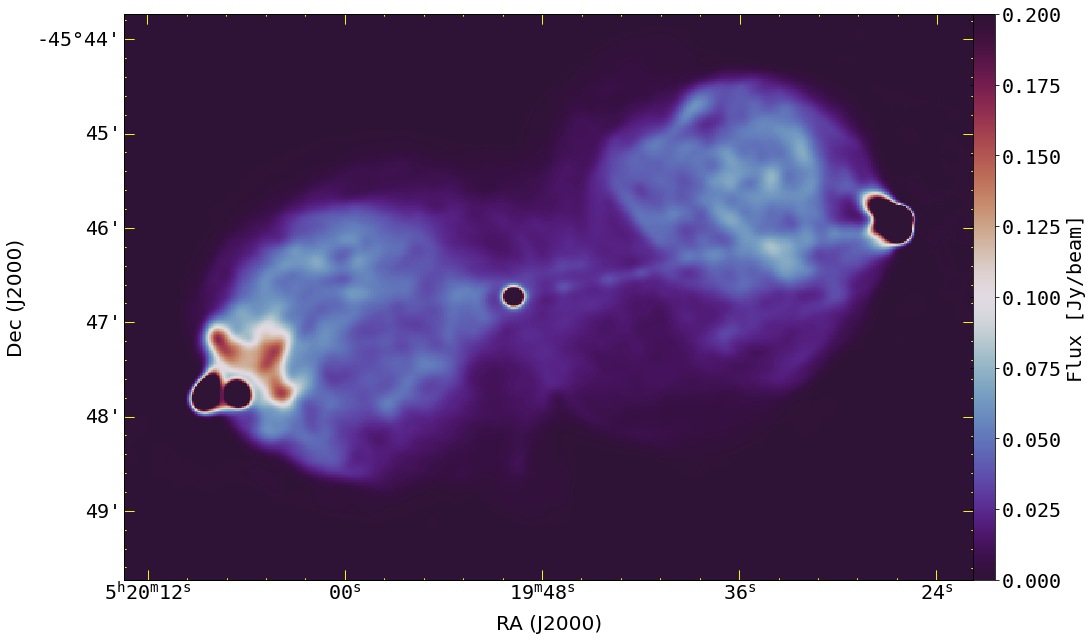

In [124]:


nl = np.array([0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1])

def fig_test(oname=None):
    # tes = "/home/andati/pica/reduction/experiments/final-cut/02-polarimetry/i-mfs.fits"
    tes = imgs[0]
    fig = plt.figure(figsize=(16,9))
    fig1 = FITSFigure(tes, figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=0.2, tcolor="yellow")

    #  i like turbo, jet, twilight, twilight_shifted, Greys
    # fig1.show_colorscale(cmap="twilight", vmin=9e-4, vmax=0.2, stretch="log")
    fig1.show_colorscale(cmap="twilight_shifted", vmin=0, vmax=0.2)

    fig1.colorbar.set_axis_label_text("Flux [Jy/beam]")
    fig1.axis_labels.set_font(size=20, weight="normal")
    fig1.tick_labels.set_font(size=20, family="monospace")
    fig1.colorbar.set_font(size=20, family="monospace")
    fig1.colorbar.set_axis_label_font(size=20, weight="normal", family="monospace")



    # fig1.ax.contour(
    #         radio_data_mkat,
    #         colors="g", origin="lower", 
    #         levels=radio_levels[::2], 
    #         # levels = contour_levels(4e-3, radio_data_mkat*mkat_4mjy_mask)[::2],
    #         linewidths=1)



    plt.tight_layout()
    print(np.diff(radio_levels[::2]))
    if oname is None:
        oname = f"{PFIGS}/test-pica-nc.svg"
    # print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=600, bbox_inches="tight")

fig_test()

In [6]:
def table2_core_flux_wfreq(cube, region, output=None):
    """
    Monitor Change in the flux of the core with frequency

    cube: str
        Name of input i image cube
    region: str
        Region under investigation e.g pica core
        Pass the name of this CTRF region file

    """

    """
    see: https://casa.nrao.edu/docs/TaskRef/imstat-task.html
    # These are the display axes, the calculation of statistics occurs  
    # for each (hyper)plane along axes not listed in the axes parameter,  
    # in this case axis 2 (the frequency axis)  
    """
    
    if output is None:
        output=f"{PFIGS}/2-table{EXT}"

    stats = imstat(cube, region=region, axes=[0,1])
    flux = stats["flux"]
    mean = stats["mean"]
    sigma = stats["sigma"]
    chans = np.arange(flux.size)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.plot(chans, flux, "ko", label="flux [Jy]")
    ax.plot(chans, snd.gaussian_filter(flux, sigma=3), "k--",
        label="flux fit")
    # ax.errorbar(chans, mean, yerr=sigma)
    ax.plot(chans, mean, "bo", label=r"$\mu$ [Jy/beam]")
    ax.plot(chans, snd.gaussian_filter(mean, sigma=3), "b--",
        label=r"$\mu$ fit ")
    ax.fill_between(chans, mean-sigma, mean+sigma, color="b",
        alpha=0.3, label=r"$\sigma$")

    ax.set_xlabel("Channel")
    ax.set_ylabel("Spectral fluxes*")
    plt.title("Flux change in Pictor A nucleus")
    plt.legend()
    print(f"Saving plot: {output}")
    
    plt.savefig(output, dpi=DPI)
    plt.close("all")



In [7]:
def table3_lobe_flux_wfreq(elobe, wlobe, output=None, smooth_sigma=10):
    """
    Monitor change of lobes' flux with frequncy
    (e|w)lobe:
        Cube of the eastern or western lobe. These can be generated using
        Fitstools in the following way:
        fitstool.py --prod i-image-cube.fits masks/west-lobe.fits -o west-lobe-cube.fits
        Note that we multiply the image x mask and not mask x image!

    see: https://casa.nrao.edu/docs/TaskRef/imstat-task.html
    # These are the display axes, the calculation of statistics occurs  
    # for each (hyper)plane along axes not listed in the axes parameter,  
    # in this case axis 2 (the frequency axis)  
    """
    from casatasks import imstat

    if output is None:
        output=f"{PFIGS}/table-lobe-fluxes.png"

    estats = imstat(elobe, axes=[0,1], stretch=True)
    wstats = imstat(wlobe, axes=[0,1], stretch=True)
    
    eflux = estats["flux"]
    wflux = wstats["flux"]

    chans = np.arange(eflux.size)

    fig, ax = plt.subplots(figsize=FIGSIZE, ncols=2, sharex=True)

    # Eastern lobe
    ax[0].plot(chans, eflux, "bo", label="flux [Jy]")
    ax[0].plot(
        chans, snd.gaussian_filter(eflux, sigma=smooth_sigma),
        "r--", label=fr"Gaussian fit {smooth_sigma}$\sigma$")

    ax[0].set_xlabel("Channel")
    ax[0].set_ylabel("Spectral fluxes*")
    ax[0].set_title(f"Eastern Lobe, Total Flux sum: {np.sum(eflux):.3f}")
    ax[0].minorticks_on()

    # Western lobe
    ax[1].plot(chans, wflux, "bo", label="flux [Jy]")
    ax[1].plot(
        chans, snd.gaussian_filter(wflux, sigma=smooth_sigma),
        "r--", label=fr"Gaussian fit {smooth_sigma}$\sigma$")

    ax[1].set_xlabel("Channel")
    ax[1].set_ylabel("Spectral fluxes*")
    ax[1].set_title(f"Western Lobe, Total Flux sum: {np.sum(wflux):.3f}")
    ax[1].minorticks_on()

    fig.suptitle("Flux change in Pictor A lobes")
    plt.legend()
    print(f"Saving plot: {output}")
    
    plt.savefig(output, dpi=DPI)
    plt.close("all")

In [8]:

def fig_3b_chandra():
    fig = plt.figure(figsize=(6,6))
    fig = FITSFigure(imgs[0], figure=fig)
    fig = basic_figure(fig, vmin=0, vmax=0.1)


    # show regions useful for the RM map
    # fig.show_regions(f"{mask_dir}/important_regions/all-components.reg")

    fig.colorbar.set_axis_label_text("Log Flux [Jy/beam]")
    fig.axis_labels.set_font(size=12, weight="normal")
    fig.tick_labels.set_font(size=12, family="monospace")
    fig.colorbar.set_font(size=12, family="monospace")
    fig.colorbar.set_axis_label_font(size=12, weight="normal")
    fig.show_colorscale(cmap="magma", vmin=.4e-3, vmax=0.1, stretch="log")

    plt.tight_layout()
    # show contours
    fig.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
        levels=xray_levels, linewidths=.5)
    # fig.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
    #     levels=radio_levels, linewidths=0.5)
        
# fig_3b_chandra()

In [9]:
c = 3e8
simple_lsq = lambda x: (c/x)**2

def rmtf_resolution(lambda_sq_min: float, lambda_sq_max: float):
    """
    Equation 61
    Approximate FWHM of the RMSF
    """
    msens = (2 * 3**0.5)/(lambda_sq_max - lambda_sq_min)
    return msens

# rmtf_resolution(simple_lsq(2625e6), simple_lsq(544e6))

INFO: Setting slices=[0, 0] [aplpy.core]


/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linestyle. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute lw. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


paper-figs-aplpy/jet-feature.svg


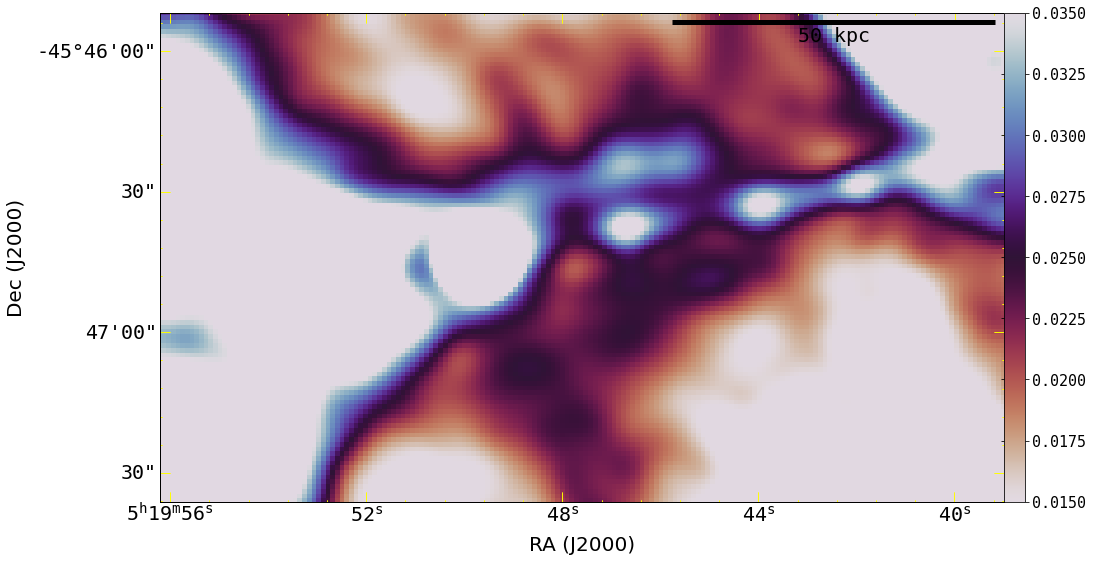

In [54]:
def fig_3b_chandra_jet_subplots(oname=None):
    fig = plt.figure(figsize=(16,9))

    fig1 = FITSFigure(imgs[0], figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=.5, cbar_loc="right", tcolor="yellow")
    fig1.recenter(x=ra_deg, y=dec_deg, width=0.05, height=0.029)
    

    fig1.show_colorscale(cmap="twilight_r", vmin=0.015, vmax=0.035, stretch="linear")

    fig1.add_scalebar(68.8025*u.arcsec)
    fig1.scalebar.set_corner("top right")
    fig1.scalebar.set_label("50 kpc")
    fig1.scalebar.set(linestyle="solid", color="black", lw=5)
    fig1.scalebar.set_font(size=20, weight="medium",
        stretch="normal", family="monospace",
        style="normal", variant="normal")

    fig1.colorbar.set_axis_label_font(size=20, weight="normal")
    fig1.colorbar.set_font(size=15, family="monospace")



    if oname is None:
        oname = f"{PFIGS}/jet-feature{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


fig_3b_chandra_jet_subplots()

INFO: Setting slices=[0, 0] [aplpy.core]


/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linestyle. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute lw. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


paper-figs-aplpy/jet-feature2.svg


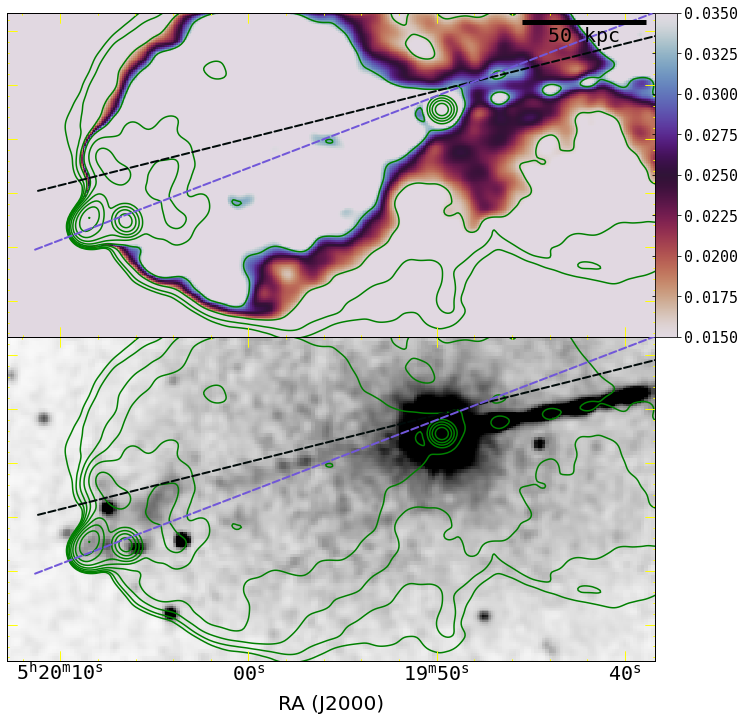

In [87]:
def fig_3b_chandra_jet_subplots_major(oname=None):



    # for centering
    # convert RA to dec
    ra = "5h19m58s"
    dec = "-45d46m44s"
    # setting an offset so that the image is centered well
    # this is in degrees
    offset = -0.01
    sk = SkyCoord(f"{ra} {dec}", frame=FK5)
    ra_deg, dec_deg = sk.ra.deg+offset, sk.dec.deg

    fig = plt.figure(figsize=(16,9))

    fig1 = FITSFigure(imgs[0], figure=fig, subplot=[0, 0.5, 1, 0.5])
    fig1 = basic_figure(fig1, vmin=0, vmax=.5, cbar_loc="right", tcolor="yellow")
    fig1.recenter(x=ra_deg, y=dec_deg-0.01, width=0.1, height=0.05)
    fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels[::2])

    fig1.show_colorscale(cmap="twilight_r", vmin=0.015, vmax=0.035, stretch="linear")
    # fig1.show_colorscale(cmap="twilight_r", vmin=0.015, vmax=0.3, stretch="log")

    fig1.add_scalebar(68.8025*u.arcsec)
    fig1.scalebar.set_corner("top right")
    fig1.scalebar.set_label("50 kpc")
    fig1.scalebar.set(linestyle="solid", color="black", lw=5)
    fig1.scalebar.set_font(size=20, weight="medium",
        stretch="normal", family="monospace",
        style="normal", variant="normal")

    fig1.colorbar.set_axis_label_font(size=20, weight="normal")
    fig1.colorbar.set_font(size=15, family="monospace")

    fig1.show_regions(f"{mask_dir}/important_regions/jet-likes.reg")
    xmin, ymin, dx, dy = fig1.ax.get_position().bounds

    fig1x = FITSFigure(chandra[1], figure=fig, subplot=[0, 0, 1, dy])
    fig1x = basic_figure(fig1x, vmin=0, vmax=.5, cbar_loc="right", tcolor="yellow")
    fig1x.recenter(x=ra_deg, y=dec_deg-0.01, width=0.1, height=0.05)
    fig1x.show_contour(radio_data_mkat, colors="green", levels=radio_levels[::2])
    fig1x.show_colorscale(vmin=0, vmax=1e-7, cmap="Greys")
    fig1x.colorbar.hide()
    fig1x.show_regions(f"{mask_dir}/important_regions/jet-likes.reg")

    fig1.tick_labels.hide_y()
    fig1x.tick_labels.hide_y()
    fig1.axis_labels.hide_y()
    fig1x.axis_labels.hide_y()
    fig1.tick_labels.hide_x()
    # fig1x.tick_labels.hide_x()
    fig1.axis_labels.hide_x()
    # fig1x.axis_labels.hide_x()


    if oname is None:
        oname = f"{PFIGS}/jet-feature2.svg"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


fig_3b_chandra_jet_subplots_major()

In [15]:
def orig_fig_3b_chandra_jet_subplots(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(imgs[0], figure=fig, subplot=[0, 0, 0.55, 1])
    fig1 = basic_figure(fig1, vmin=0, vmax=.2, cbar_loc="top")

    fig1.colorbar.set_axis_label_text("Flux [Jy/beam]")
    # radio contours
   
    # fig1.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
    #     levels=radio_levels, linewidths=0.5
    #     )

    # jet on the side
    xmin, dx = 0.56, 0.4
    ymin, dy = 0, 1
    jet = FITSFigure(imgs[0], figure=fig, subplot=[xmin, ymin, dx, dy])
    jet = make_inset(jet, cmap="magma", vmin=0, vmax=0.05,
        center=dict(x=ra_deg-.04, y=dec_deg, radius=0.037), no_ticks=False,
        )

    jet.show_colorscale(cmap="magma", vmin=4e-3, vmax=0.08, stretch="power", exponent=2)
    
    jet.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
        levels=radio_levels, linewidths=0.5)
    jet.tick_labels.set_yposition("right")
    # jet.tick_labels.hide()
    
    

    # eastern hotspot
    ehs = FITSFigure(imgs[0], figure=fig, subplot=[0.01, 0.7, 0.27, 0.26])
    ehs = make_inset(ehs, cmap="magma", vmin=0, vmax=0.5,
        center=dict(x=ra_deg+.07, y=dec_deg-0.02, radius=0.01)
        )
    
    ehs.show_contour(radio_data_mkat, colors="green", smooth=1, kernel="gauss",
        levels=radio_levels, linewidths=0.5)
    ehs.show_colorscale(cmap="magma", vmin=0, vmax=1)


    # chandra contours
    # fig1.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5
    #     )

    # jet.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5)

    # ehs.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.5)

    fig1.ax.indicate_inset_zoom(ehs.ax, edgecolor="yellow", lw=2)
    # fig1.ax.indicate_inset_zoom(jet.ax, edgecolor="yellow", lw=2)


    if oname is None:
        oname = f"{PFIGS}/pictor-a{EXT}"
    # print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


# orig_fig_3b_chandra_jet_subplots()

In [12]:
def figure_4b_intensity_contours(oname=None):
    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(imgs[0], figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=0.7, cbar_loc="right", tcolor="yellow")

    # fig1.show_contour(radio_data_mkat, colors="green", smooth=13, kernel="gauss",
    #     levels=radio_levels, linewidths=1)
    
    fig1.ax.contour(
            snd.gaussian_filter(radio_data_mkat, sigma=13),
            colors="g", origin="lower", levels=radio_levels, linewidths=1)

    # fig1.colorbar.set_axis_label_text("Flux [Jy/beam]")
    fig1.colorbar.hide()

    if oname is None:
        oname = f"{PFIGS}/intensity-contours{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_4b_intensity_contours()

In [13]:
def figure_5b_spi_wintensity_contours(oname=None):
    
    fig = plt.figure(figsize=FIGSIZE)

    spi_data = get_data(spi_map) * mkat_4mjy_mask
    
    fig1 = FITSFigure(
        make_hdu(spi_map, spi_data),
        figure=fig)

    fig1 = basic_figure(fig1, vmin=-1.3, vmax=-0.5, cbar_loc="right", cmap="coolwarm_r")
   
   
    # fig1.ax.contour(
    #         # snd.gaussian_filter(radio_data_mkat, sigma=13),
    #         radio_data_mkat,
    #         colors="g", origin="lower", levels=radio_levels, linewidths=1,)
   
    fig1.colorbar.set_axis_label_text("Spectral index")
    # fig1.show_colorscale(cmap="coolwarm_r")
    fig1.set_nan_color("white")
    if oname is None:
        oname = f"{PFIGS}/spi-intensity-contours{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    # plt.show()

# figure_5b_spi_wintensity_contours()


In [6]:


def figure_5b_spi_err_wintensity_contours(oname=None):
    fig = plt.figure(figsize=(9,12))



    spi_data = get_data(spi_map) * mkat_4mjy_mask
    
    spi = FITSFigure(make_hdu(spi_map, spi_data), figure=fig, subplot=[0, 0.5, 1, 0.5])


    spi = basic_figure(spi, vmin=-1.3, vmax=-0.5, cbar_loc="right", cmap="coolwarm_r")
   
   
    # spi.ax.contour(
    #         # snd.gaussian_filter(radio_data_mkat, sigma=1),
    #         radio_data_mkat,
    #         colors="k", origin="lower", levels=radio_levels, linewidths=1)
    # spi.show_colorscale(vmin=-1.7, vmax=-0.5, cmap="coolwarm_r")
   
    spi.colorbar.set_axis_label_text("Spectral index")
    spi.colorbar.set_axis_label_font(size=20, weight="normal")
    spi.colorbar.set_font(size=20, family="monospace")
    # spi.ticks.hide_x()
    spi.tick_labels.hide_x()
    spi.axis_labels.hide_x()

    spi_err_data = get_data(spi_err_map) * mkat_4mjy_mask


    xmin, ymin, dx, dy = spi.ax.get_position().bounds
    
    spierr = FITSFigure(make_hdu(spi_err_map, spi_err_data), figure=fig,
        subplot=[0, 0, 1, 0.5])


    spierr = basic_figure(spierr, vmin=1e-3, vmax=7e-3, cbar_loc="right", cmap="coolwarm")
   

    spierr.colorbar.set_axis_label_text("Spectral index error")
    spierr.show_colorscale(cmap="coolwarm",  vmin=1e-3, vmax=7e-3, stretch="log")
    spierr.colorbar.set_axis_label_font(size=20, weight="normal")
    spierr.colorbar.set_font(size=15, family="monospace")

    spi.set_nan_color("white")
    spierr.set_nan_color("white")


    if oname is None:
        oname = f"{PFIGS}/spi-werr-intensity-contours{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_5b_spi_err_wintensity_contours()


In [15]:
# read channelised image off source errors so that we get fpol and depol errors
npz = read_npz(f"{products}/scrap-outputs-s3/los-data/reg_1.npz")
ierr, qerr, uerr = npz["I_err"][[0,-1]], npz["Q_err"][[0,-1]], npz["U_err"][[0,-1]]


In [16]:
def figure_9a_fractional_poln_error(oname=None, make_fpol_mask=False):    
    fp_data = get_data(fp_map) * mkat_4mjy_mask

    # fpol at the lowerst and hidhest freq
    i_data = fits.getdata(cubes[0]).squeeze()[[0,-1]]
    q_data = fits.getdata(cubes[1]).squeeze()[[0,-1]]
    u_data = fits.getdata(cubes[2]).squeeze()[[0,-1]]
    
    # select the highest freq
    freq = -1
    
    fpol = frac_polzn(i_data, q_data, u_data)[freq] * mkat_4mjy_mask * snr_mask
    
    # mask 75> fpol > 0
    fpol = np.ma.masked_outside(fpol, 0, 0.8)
    fpol_err = frac_polzn_error(i_data[freq], q_data[freq], u_data[freq],
                                ierr[freq], qerr[freq], uerr[freq]) *mkat_4mjy_mask * snr_mask

    
    if make_fpol_mask:
        #-----------------------------
        # making the fpol mask
        #-----------------------------
        test = np.ma.masked_greater_equal(fpol_err/fpol, 0.6)
        test = np.ma.masked_invalid(test)
        fits.writeto(filename=f"{mask_dir}/fpol-err-limit-mask.fits",
                data=(~test.mask).astype("uint8"),
                header=fits.getheader(smask), overwrite=True)
        #-----------------------------

    fig = plt.figure(figsize=FIGSIZE)
    
    # depoln_hdu = make_hdu(fp_map, depoln)
    fig1 = FITSFigure(make_hdu(fp_map, fpol_err), figure=fig)
    
    fig1 = basic_figure(fig1, vmin=None, vmax=None, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels)
    fig1.colorbar.set_axis_label_text("Degree of Polarisation Error")
    fig1.set_nan_color("white")

    if oname is None:
        oname = f"{PFIGS}/dop-error{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_9a_fractional_poln_error()

In [17]:
depolzn_err = lambda fp1, fp_err1, fp2, fp_err2: np.sqrt(np.square(fp_err1/fp1) + np.square(fp_err2/fp2))

def figure_14_depolarisation_err(oname=None, make_depol_mask=False):
    i_data = fits.getdata(cubes[0]).squeeze()[[0,-1]]
    q_data = fits.getdata(cubes[1]).squeeze()[[0,-1]]
    u_data = fits.getdata(cubes[2]).squeeze()[[0,-1]]


    fpol = frac_polzn(i_data, q_data, u_data) * fpol_mask * snr_mask
    fpol_err0 = frac_polzn_error(i_data[0], q_data[0], u_data[0], ierr[0], qerr[0], uerr[0]) * fpol_mask * snr_mask
    fpol_err1 = frac_polzn_error(i_data[1], q_data[1], u_data[1], ierr[1], qerr[1], uerr[1]) * fpol_mask * snr_mask

    depoln = fpol[0]/fpol[-1]    
    depoln_err = depolzn_err(fpol[0], fpol_err0, fpol[1], fpol_err1)

    
    if make_depol_mask:
        # #-----------------------------
        # # making depoln mask
        #-----------------------------
        # # ratio of 0.6 and 0.8 yield almost similar results
        # # Below just mask out any region where this ratio as approaching 1
        # # meanining the noise is getting bigger
        test = np.ma.masked_greater_equal(depoln_err/depoln, 0.6)
        test = np.ma.masked_invalid(test)
        fits.writeto(filename=f"{mask_dir}/depol-err-limit-mask.fits",
                data=(~test.mask).astype("uint8"),
                header=fits.getheader(smask), overwrite=True)
        #-----------------------------

    # manually create hdu for aplpy, otherwise becomes problematic    
    depoln_hdu = make_hdu(fp_map, depoln_err)

    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(depoln_hdu, figure=fig)
    
    fig1 = basic_figure(fig1, vmin=None, vmax=None, cbar_loc="right", cmap="coolwarm")
    fig1.colorbar.set_axis_label_text("Depolarization ratio error")
    fig1.set_nan_color("white")

    # fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels, linewidths=1)

    if oname is None:
        oname = f"{PFIGS}/14-depolzn-err{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")   

# figure_14_depolarisation_err(make_depol_mask=False)

In [18]:
def figure_8_ti_magnetic_fields_contours(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(WCS(fits.getheader(fp_map)), figure=fig)
    fig1 = basic_figure(fig1, cbar_loc=None)

    fig1.ax.contour(radio_data_mkat,
            colors="k", linewidths=0.5, origin="lower", levels=radio_levels)
       
    bx = fig1.ax.contourf(
        radio_data_mkat ,
        cmap="coolwarm", origin="lower", levels=radio_levels,
        locator=ticker.LogLocator()
        )
    
    fig.colorbar(bx, pad=0, label="Flux [Jy/beam]",
        drawedges=False, location="right")
    fig1.set_nan_color("white")
    
    
    fp_data = rfu.get_masked_data(fp_map, fmask) 
    angle_data = rfu.get_masked_data(pangle_map, fmask)
    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
            angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    fp_data = fp_data[slicex, slicey]

    # nornalize this
    
    scales = fp_data / np.ma.max(fp_data)

    # scale as amplitude

    u = scales * np.cos(angle_data)
    v = scales * np.sin(angle_data)
    # u = v = np.ones_like(angle_data) * scales

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0022, scale=20, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/ti-contours-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_8_ti_magnetic_fields_contours()

In [19]:
def figure_8b_dop_magnetic_fields_contours(oname=None):

    # masking the data with nans upto 4mjy
    fp_data = get_data(fp_map) * fpol_mask * snr_mask
    angle_data = get_data(pangle_map) * fpol_mask * snr_mask

    fp_hdu = make_hdu(fp_map, fp_data)


    fig = plt.figure(figsize=FIGSIZE)
    
    fig1 = FITSFigure(fp_hdu, figure=fig)
    fig1 = basic_figure(fig1, cmap="coolwarm", vmin=1e-3, vmax=0.5)
    
    # fig1.show_contour(radio_data_mkat, 
    #     colors="g", levels=radio_levels, linewidths=0.5)


    fig1.colorbar.set_axis_label_text("Degree of polarisation") 
    fig1.set_nan_color("white")

    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
        print("converting radians to degrees")
        angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    
    scales = 0.04

    # scale as amplitude
    # remember to mask these also so that the arrows are confined within the source
    u = np.full_like(angle_data, scales)
    u[np.where(np.isnan(angle_data))] = np.nan
    v = u

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0022, scale=5, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/dop-contours-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_8b_dop_magnetic_fields_contours()

In [8]:
def figure_9a_fractional_poln(oname=None):
    fp_data = get_data(fp_map) * fpol_mask * snr_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(fp_map, fp_data), figure=fig)
    
    fig1 = basic_figure(fig1, vmin=1e-3, vmax=0.5, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, colors="green", levels=radio_levels)
    fig1.colorbar.set_axis_label_text("Degree of Polarisation")
    fig1.set_nan_color("white")

    if oname is None:
        oname = f"{PFIGS}/dop-mfs.pdf"

    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_9a_fractional_poln()

In [21]:
def figure_10_linear_poln(oname=None):

    lp_data = get_data(lp_map) * mkat_4mjy_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(lp_map, lp_data), figure=fig)

    fig1 = basic_figure(fig1, vmin=5e-3, vmax=5e-2, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, colors="k", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text("Linear polarised intensity")
    fig1.set_nan_color("white")

    if oname is None:
        oname = f"{PFIGS}/lpol-mfs{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

# figure_10_linear_poln()

In [22]:
def figure_14_depolarisation(oname=None):
    i_data = fits.getdata(cubes[0]).squeeze()[[0,-1]]
    q_data = fits.getdata(cubes[1]).squeeze()[[0,-1]]
    u_data = fits.getdata(cubes[2]).squeeze()[[0,-1]]


    fpol = frac_polzn(i_data, q_data, u_data) * depol_mask
    depoln = fpol[0]/fpol[-1]    


    # manually create hdu for aplpy, otherwise becomes problematic
    
    depoln_hdu = make_hdu(fp_map, depoln)

    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(depoln_hdu, figure=fig)
    
    fig1 = basic_figure(fig1, vmin=0, vmax=2, cbar_loc="right", cmap="coolwarm")
    fig1.colorbar.set_axis_label_text("Depolarisation ratio")
    fig1.set_nan_color("white")

    # fig1.show_contour(radio_data_mkat, colors="k", levels=radio_levels, linewidths=0.5)

    if oname is None:
        oname = f"{PFIGS}/depolzn{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")   

# figure_14_depolarisation()
    

In [9]:
def report_data(data, bins=50, ranges=(-100, 100),side="East"):
    mean = np.nanmean(data)
    std = np.nanstd(data)
    counts, values = np.histogram(data, bins=bins, range=ranges, density=False)
    max_count = counts.max()
    cluster_center = values[np.argmax(counts)]
    
    with open(f"{PFIGS}/lobe-stats.txt", mode="a") as sfile:
        sfile.write
        sfile.write("-----------------------------\n")
        sfile.write(side+"\n")
        sfile.write("-----------------------------\n")
        sfile.write(f"mean           : {mean:10.2f}\n")
        sfile.write(f"std            : {std:10.2f}\n")
        sfile.write(f"Max bin count  : {max_count:10.2f}\n")
        sfile.write(f"Bin center     : {cluster_center:10.2f}\n")
        sfile.write("\n")
    return


In [22]:
show_regs = [
    ("for-publication/00-hi-snr.reg", "2", "purple"),
    ("for-publication/01-boundary-regs.reg", "+", "black"),
    ("for-publication/02-low-snr.reg", "x", "yellow")
]

def get_pixels(fname, iname, marker):
    wcs = WCS(fits.getheader(iname))
    regs = Regions.read(fname, format="ds9").regions

    pixels = []
    for reg in regs:
        try:
            xy = reg.to_pixel(wcs).center.xy
        except:
            bn = reg.to_pixel(wcs)
            bst = bn.end - bn.start
            xy = (bn.start.x + (bst.x/2)), (bn.start.y + (bst.y/2))
        pixels.append((xy, marker))

    return pixels

def add_regions(fig, reg_list):
    """
    fig: aplpy.Fig
        Aplpy figure object which appending will be dome
    reg_list: list
        List containing tuples in the followin format
        (regfile_name, reg_marker, marker_color)
    """
    for rfile, marker, color in reg_list:
        pixels = get_pixels(rfile, rm_map, marker)
        for px in pixels:
            fig.ax.plot(*px[0], marker=px[1], markersize=30, color=color,mew=4, alpha=0.9)
            fig.ax.plot(*px[0], marker=".", color="black", zorder=100)
    return fig


def figure_rm_map(oname=None):
    
    rm_data = get_data(rm_map) * fpol_mask
    fig = plt.figure(figsize=(10,9))
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig)
    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right",
        cmap="coolwarm") 

    fig1 = add_regions(fig1, show_regs)
    fig1.recenter(ra_deg, dec_deg, width=0.13, height=0.05)
   
    # fig1.show_contour(radio_data_mkat, 
    #     colors="green", 
    #     # cmap="coolwarm", filled=True
    #     levels=radio_levels, linewidths=1)
    
    fig1.colorbar.set_axis_label_text(f"RM rad/m$^{2}$")
    fig1.set_nan_color("white")

    if oname is None:
        oname = f"{PFIGS}/rm-map{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=400, bbox_inches="tight")
    
# figure_rm_map()

In [25]:
def figure_12_13_rm_lobes_histogram(oname=None):


    rm_data = get_data(rm_map) * fpol_mask
    
    fig = plt.figure(figsize=FIGSIZE)

    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig, subplots=[0.0, 0.0, .75, .75])


    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat*mkat_4mjy_mask, colors="black", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text(r"Rotation measures rad/m$^{2}$")
    # fig1.set_nan_color("white")
    fig1.show_regions(f"{mask_dir}/important_regions/all-components-4pp.reg")
    
    fig1.colorbar.set_location("bottom")
    fig1.colorbar.set_pad(0.8)
    fig1.set_nan_color("white")

    # entire source
    rm_lobes_data = (rfu.get_masked_data(rm_map, lmask)*fpol_mask).compressed()
    # only west lobe
    w_lobe_data = (rfu.get_masked_data(rm_map, wmask)*fpol_mask).compressed()
    # only east love
    e_lobe_data = (rfu.get_masked_data(rm_map, emask)*fpol_mask).compressed()

    bins = 50
    log = False

    # ###################################
    # Report lobe stats
    # ###################################
    cost = dict(full_source=rm_lobes_data, west_lobe=w_lobe_data, east_lobe=e_lobe_data)

    os.remove(f"{PFIGS}/lobe-stats.txt")
    for side, data in cost.items():
        report_data(data, bins=bins, side=side.replace("_", " "))
    # ###################################

    # current figure dimensions
    xmin, ymin, dx, dy = fig1.ax.get_position().bounds
    # [x, y, dx, dy]
    top_hist = fig.add_axes([xmin, ymin+dy, dx , 1-dy])
    top_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="vertical",fill=False, ls="--", lw=1, edgecolor="red", range=(-100, 100),
        density=True, label="Source RMs",
        histtype="step")
    top_hist.hist(e_lobe_data, bins=bins, log=log,
        orientation="vertical", fill=False, ls="-", lw=1, edgecolor="blue", range=(-100, 100),
        density=True, label="East lobe",
        histtype="step")
    
    top_hist = beautify_histogram(
        top_hist,
        title="Eastern Lobe RM Distribution", 
        dim="y")
    
    right_hist = fig.add_axes([xmin+dx, ymin, 1-(xmin+dx), dy])
    right_hist.hist(rm_lobes_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="--", lw=1,
        edgecolor="red",density=True, label="Source RMs", range=(-100, 100),
        histtype="step")
    right_hist.hist(w_lobe_data, bins=bins, log=log,
        orientation="horizontal",fill=False, ls="-", lw=1,
        edgecolor="blue",density=True, label="West lobe", range=(-100, 100),
        histtype="step")

    right_hist = beautify_histogram(
        right_hist,
        title="Western Lobe RM Distribution", 
        dim="x")


    top_hist.legend(loc="upper left")
    right_hist.legend(loc="lower right")



    if oname is None:
        oname = f"{PFIGS}/rm-lobes{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    


# figure_12_13_rm_lobes_histogram()

/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")


paper-figs-aplpy/rm-lobes-with-ricks.pdf


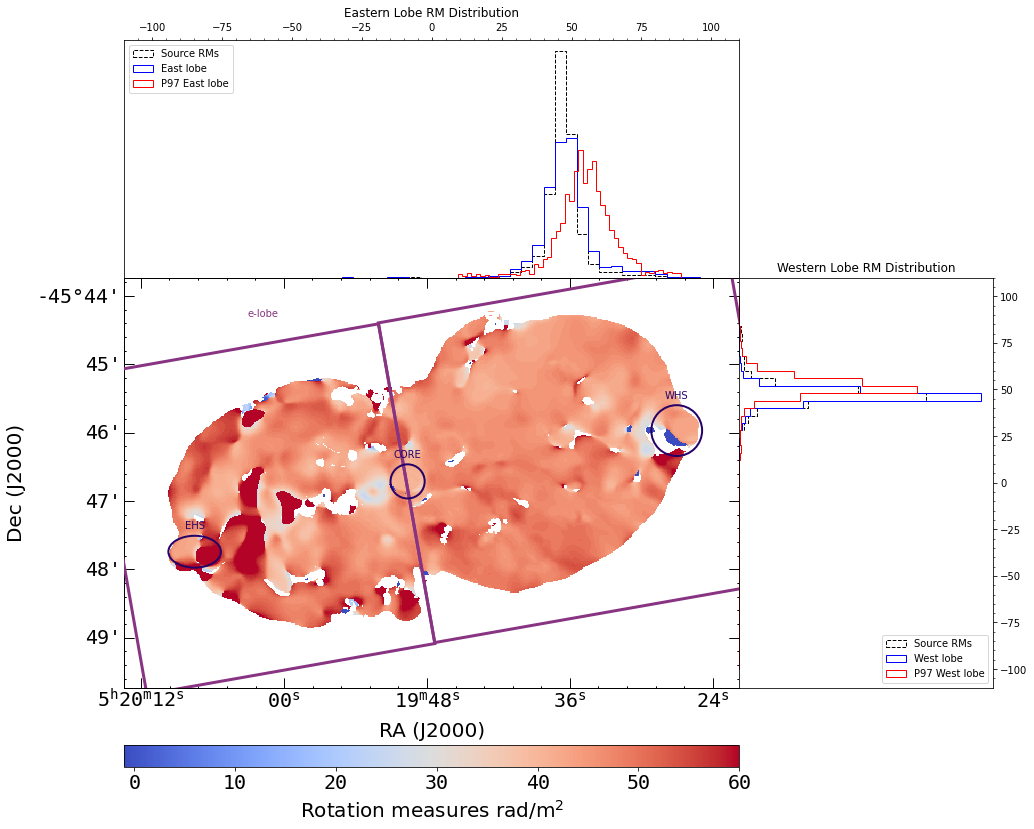

In [12]:
def figure_12_13_rm_lobes_histogram_rick(oname=None):

    
    rm_data = get_data(rm_map) * fpol_mask
    fig = plt.figure(figsize=FIGSIZE)
    
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig, subplots=[0.0, 0.0, .75, .75])

    fig1 = basic_figure(fig1, vmin=-1, vmax=60, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat*mkat_4mjy_mask, colors="black", levels=radio_levels, linewidths=0.5)
    fig1.colorbar.set_axis_label_text(r"Rotation measures rad/m$^{2}$")
    fig1.show_regions(f"{mask_dir}/important_regions/all-components-4pp.reg")
    
    fig1.colorbar.set_location("bottom")
    fig1.colorbar.set_pad(0.8)
    fig1.set_nan_color("white")
    
    # entire source
    rm_lobes_data = (rfu.get_masked_data(rm_map, lmask)*fpol_mask).compressed()
    # only west lobe
    w_lobe_data = (rfu.get_masked_data(rm_map, wmask)*fpol_mask).compressed()
    # only east love
    e_lobe_data = (rfu.get_masked_data(rm_map, emask)*fpol_mask).compressed()

    rw_lobe = rfu.get_masked_data(vla_lband_rm, r_wmask).compressed()
    re_lobe = rfu.get_masked_data(vla_lband_rm, r_emask).compressed()


    bins = 50
    log = False


    # ###################################
    # Report lobe stats
    # ###################################
    cost = dict(full_source=rm_lobes_data, west_lobe=w_lobe_data, east_lobe=e_lobe_data,
            rick_west_lobe=rw_lobe, rick_east_lobe=re_lobe)

    for side, data in cost.items():
        report_data(data, bins=bins, side=side.replace("_", " "))
    # ###################################
   

    # current figure dimensions
    xmin, ymin, dx, dy = fig1.ax.get_position().bounds
    # [x, y, dx, dy]
    top_hist = fig.add_axes([xmin, ymin+dy, dx , 1-dy])
    top_hist.hist(rm_lobes_data, bins=bins, log=log, range=(-100, 100),
        orientation="vertical",fill=False, ls="--", lw=1, edgecolor="black",
        density=True, label="Source RMs",
        histtype="step")
    top_hist.hist(e_lobe_data, bins=bins, log=log, range=(-100, 100),
        orientation="vertical", fill=False, ls="-", lw=1, edgecolor="blue",
        density=True, label="East lobe",
        histtype="step")
    
    
    top_hist.hist(re_lobe, bins=bins, log=log,
            orientation="vertical",fill=False, ls="-", lw=1,
            edgecolor="red",density=True, label="P97 East lobe",
            histtype="step")
    top_hist.legend(loc="upper left")
    
    top_hist = beautify_histogram(
        top_hist,
        title="Eastern Lobe RM Distribution", 
        dim="y")
    
    right_hist = fig.add_axes([xmin+dx, ymin, 1-(xmin+dx), dy])
    right_hist.hist(rm_lobes_data, bins=bins, log=log, range=(-100, 100),
        orientation="horizontal",fill=False, ls="--", lw=1,
        edgecolor="black",density=True, label="Source RMs",
        histtype="step")
    
    right_hist.hist(w_lobe_data, bins=bins, log=log, range=(-100, 100),
        orientation="horizontal",fill=False, ls="-", lw=1,
        edgecolor="blue",density=True, label="West lobe",
        histtype="step")

    right_hist.hist(rw_lobe, bins=bins, log=log, range=(-100, 100),
            orientation="horizontal", fill=False, ls="-", lw=1, edgecolor="red",
            density=True, label="P97 West lobe",
            histtype="step")

    right_hist.legend(loc="lower right")

    right_hist = beautify_histogram(
        right_hist,
        title="Western Lobe RM Distribution", 
        dim="x")

    if oname is None:
        oname = f"{PFIGS}/rm-lobes-with-ricks{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")    


figure_12_13_rm_lobes_histogram_rick()

In [27]:
def figure_rm_map_b_with_mf(oname=None):

    rm_data = get_data(rm_map) * fpol_mask
    fig = plt.figure(figsize=FIGSIZE)
    fig1 = FITSFigure(make_hdu(rm_map, rm_data), figure=fig)

    fig1 = basic_figure(fig1, vmin=-60, vmax=60, cbar_loc="right", cmap="coolwarm")
    # fig1.show_contour(radio_data_mkat, 
    #     colors="green", 
    #     # cmap="coolwarm", filled=True
    #     levels=radio_levels, linewidths=1)
    fig1.colorbar.set_axis_label_text(f"Rotation measures rad/$m^{2}$")
    fig1.set_nan_color("white")


    fp_data = rfu.get_masked_data(fp_map, fmask)
    angle_data = rfu.get_masked_data(pangle_map, fmask)
    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
            angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = (angle_data + ROT)

    skip = 7
    slicex = slice(None, fp_data.shape[0], skip)
    slicey = slice(None, fp_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    fp_data = fp_data[slicex, slicey]

    # nornalize this
    
    scales = fp_data / np.ma.max(fp_data)

    # scale as amplitude
    u = scales * np.cos(angle_data)
    v = scales * np.sin(angle_data)
    # u = v = np.ones_like(angle_data) * scales

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0012, scale=20, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/rm-map-wmf{EXT}"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


# figure_rm_map_b_with_mf()

converting radians to degrees
paper-figs-aplpy/peak-fdf-map-wmf.png


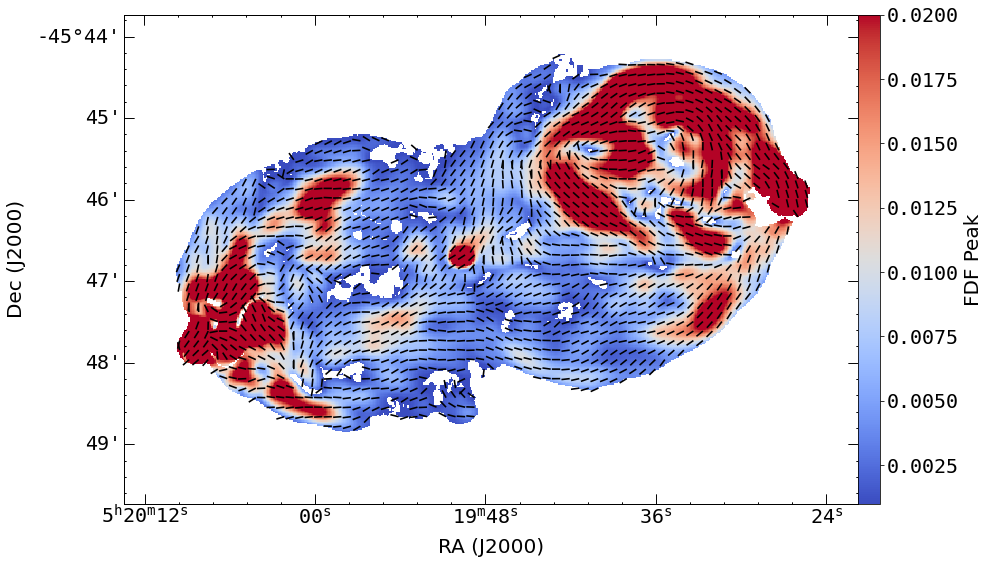

In [92]:
def figure_peak_fdf_map_with_mf(oname=None):


    # masking the data with nans upto 4mjy
    peak_data = get_data(peak_map) * fpol_mask * snr_mask
    angle_data = get_data(pangle_map) * fpol_mask * snr_mask

    fp_hdu = make_hdu(peak_map, peak_data)


    fig = plt.figure(figsize=FIGSIZE)
    
    fig1 = FITSFigure(fp_hdu, figure=fig)
    fig1 = basic_figure(fig1, cmap="coolwarm", vmin=1e-3, vmax=2e-2)
    
    # fig1.show_contour(radio_data_mkat, 
    #     colors="g", levels=radio_levels, linewidths=0.5)


    fig1.colorbar.set_axis_label_text("FDF Peak") 
    fig1.set_nan_color("white")

    
    if "rad" in fits.getheader(pangle_map)["BUNIT"].lower():
        print("converting radians to degrees")
        angle_data = np.rad2deg(angle_data)
    
    # rotate the e vectors 
    angle_data = angle_data + ROT

    skip = 7
    slicex = slice(None, peak_data.shape[0], skip)
    slicey = slice(None, peak_data.shape[-1], skip)
    col, row = np.mgrid[slicex, slicey]

    # get M vector by rotating E vector by 90
    angle_data = angle_data[slicex, slicey]
    
    scales = 0.04

    # scale as amplitude
    # remember to mask these also so that the arrows are confined within the source
    u = np.full_like(angle_data, scales)
    u[np.where(np.isnan(angle_data))] = np.nan
    v = u

    fig1.ax.quiver(
        row, col, u, v, angles=angle_data, pivot='tail', headlength=0,
        width=0.0022, scale=5, headwidth=1, color="black")
    
    if oname is None:
        oname = f"{PFIGS}/peak-fdf-map-wmf.png"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")


figure_peak_fdf_map_with_mf()

In [89]:

def missing_radio_flux(oname=None):
    fig = plt.figure(figsize=FIGSIZE)

    # # radio - xray
    # fig1 = FITSFigure(imgs[0], figure=fig)
    # fig1 = basic_figure(fig1, vmin=0.4e-3, vmax=0.1, cbar_loc="right", tcolor="yellow")
    # fig1.set_nan_color("white")
    # # show contours
    # fig1.show_contour(chandra[0], colors="green", smooth=1, kernel="gauss",
    #     levels=xray_levels, linewidths=0.8
    #     )
    # # fig1.colorbar.set_axis_label_text(f"Flux [Jy/beam]")
    # fig1.show_colorscale(vmin=0.4e-3, vmax=0.5, cmap="magma", stretch="log")
    # fig1.colorbar.hide()



    # xray - radio
    fig1 = FITSFigure(chandra[0], figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=0.1, cbar_loc="right", tcolor="black")
    fig1.set_nan_color("white")
    # show contours
    fig1.show_contour(radio_data_mkat, colors="tab:blue", smooth=1, kernel="gauss",
        levels=contour_levels(.6e-3, radio_data_mkat*mkat_4mjy_mask), linewidths=1
        )
    
    atca = "/home/andati/pica/reduction/from-lenc-atca-radio-hdr/cabb-5.5ghz-peel-7asec-proj-4k.fits"
    atca_levels = 0.6e-3 * 2**np.arange(12)
    # fig1.show_contour(get_data(atca), colors="red", levels=atca_levels, linewidths=1, linestyles="dashed")


    # for the 7arcsec image
    fig1.show_colorscale(vmin=3e-7, vmax=.13e-5, cmap="Greys", stretch="log")


    # fig1.show_colorscale(vmin=1.2e-8, vmax=2.5e-7, cmap="Greys", stretch="log")

    # the default norma
    # fig1.show_colorscale(vmin=0, vmax=1e-7, cmap="Greys")
    fig1.colorbar.hide()

    if oname is None:
        oname = f"{PFIGS}/missing-flux.svg"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")
    
# missing_radio_flux()

In [29]:
def run_papermill():
    print("----------------------------")
    print("Running paper mill")
    print("----------------------------")
    
    table2_core_flux_wfreq(cubes[0],
        region=f"{mask_dir}/important_regions/hotspots/core-ctrf")
    table3_lobe_flux_wfreq(elobe=f"{products}/east-lobe-cube.fits",
        wlobe=f"{products}/west-lobe-cube.fits")
    
    fig_3b_chandra_jet_subplots()
    figure_4b_intensity_contours()
    figure_5b_spi_wintensity_contours()
    figure_5b_spi_err_wintensity_contours()

    figure_8_ti_magnetic_fields_contours()
    figure_8b_dop_magnetic_fields_contours()
    
    figure_9a_fractional_poln_error()
    figure_14_depolarisation_err()
    
    figure_9a_fractional_poln()
    figure_10_linear_poln()
    figure_14_depolarisation()

    
    # Lobe stuff
    figure_12_13_rm_lobes_histogram()
    figure_12_13_rm_lobes_histogram_rick()


    # figure_rm_map()
    figure_rm_map_b_with_mf()
    missing_radio_flux()

    print("----------------------------")
    print("Paper mill stopped")
    print("----------------------------")

----------------------------
Running paper mill
----------------------------
Saving plot: paper-figs-aplpy/2-table.pdf


....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%


Saving plot: paper-figs-aplpy/table-lobe-fluxes.png
INFO: Setting slices=[0, 0] [aplpy.core]


/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute linestyle. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/home/andati/git_repos/aplpy/aplpy/overlays.py:256: UserWarning: Text labels do not have attribute lw. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))


INFO: Setting slices=[0, 0] [aplpy.core]


INFO: Setting slices=[0, 0] [aplpy.core]


paper-figs-aplpy/3-pictor-a.pdf
INFO: Setting slices=[0, 0] [aplpy.core]
paper-figs-aplpy/intensity-contours.pdf
paper-figs-aplpy/spi-intensity-contours.pdf
paper-figs-aplpy/spi-werr-intensity-contours.pdf
INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  0.000e+00 [aplpy.core]
paper-figs-aplpy/ti-contours-mfs.pdf
converting radians to degrees
paper-figs-aplpy/dop-contours-mfs.pdf
INFO: Auto-setting vmin to -9.546e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.174e-02 [aplpy.core]
paper-figs-aplpy/dop-error.pdf
INFO: Auto-setting vmin to -1.673e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.912e+00 [aplpy.core]
paper-figs-aplpy/14-depolzn-err.pdf
paper-figs-aplpy/dop-mfs.pdf
paper-figs-aplpy/lpol-mfs.pdf
paper-figs-aplpy/depolzn.pdf


/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")


paper-figs-aplpy/rm-lobes.pdf


/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")
/home/andati/git_repos/aplpy/aplpy/colorbar.py:100: UserWarning: Bottom colorbar not fully implemented
  warnings.warn("Bottom colorbar not fully implemented")


paper-figs-aplpy/rm-lobes-with-ricks.pdf


NameError: name 'figure_rm_map_b_with_mf' is not defined

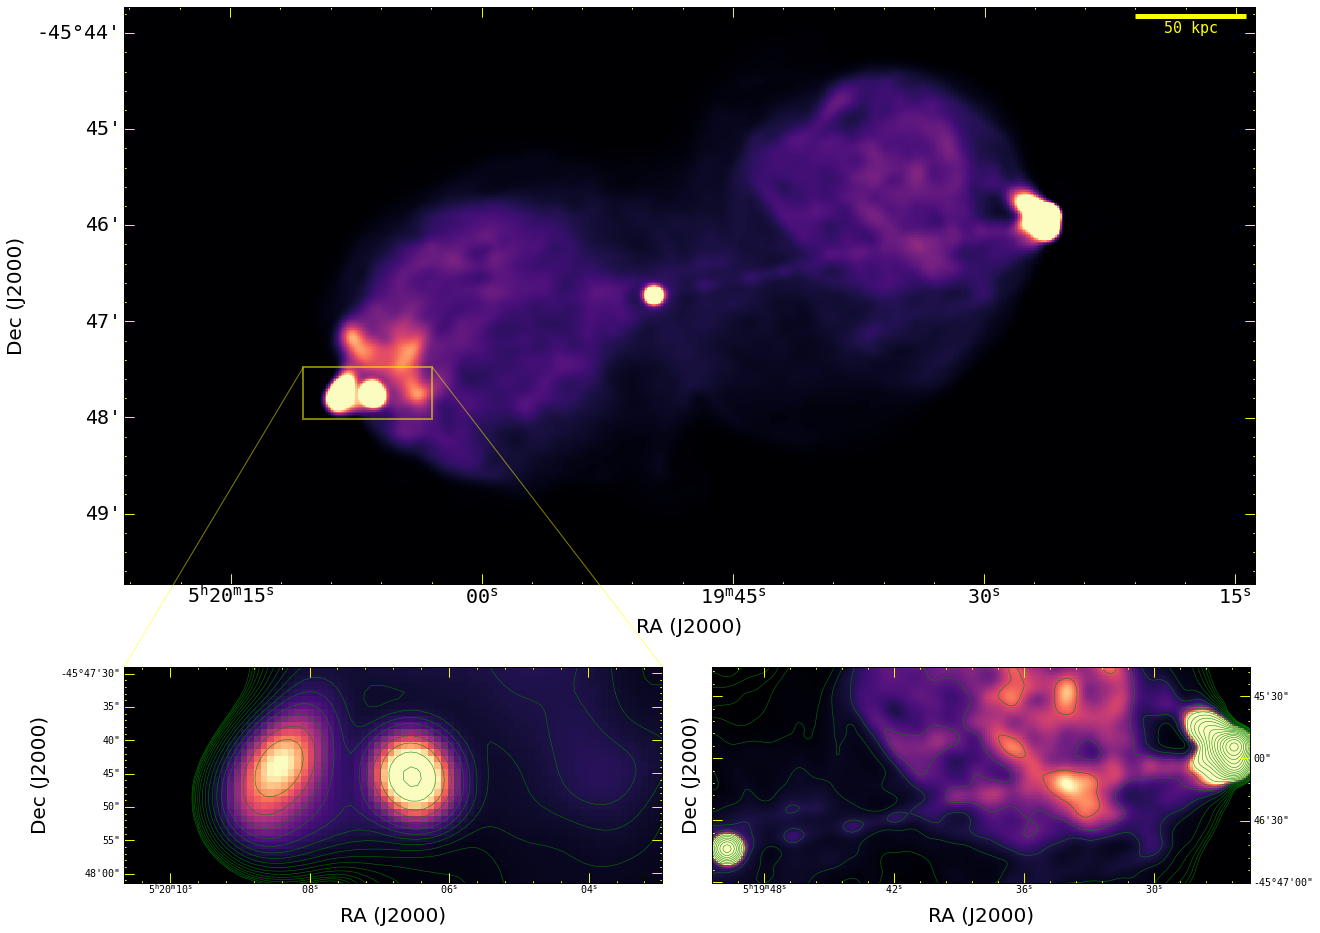

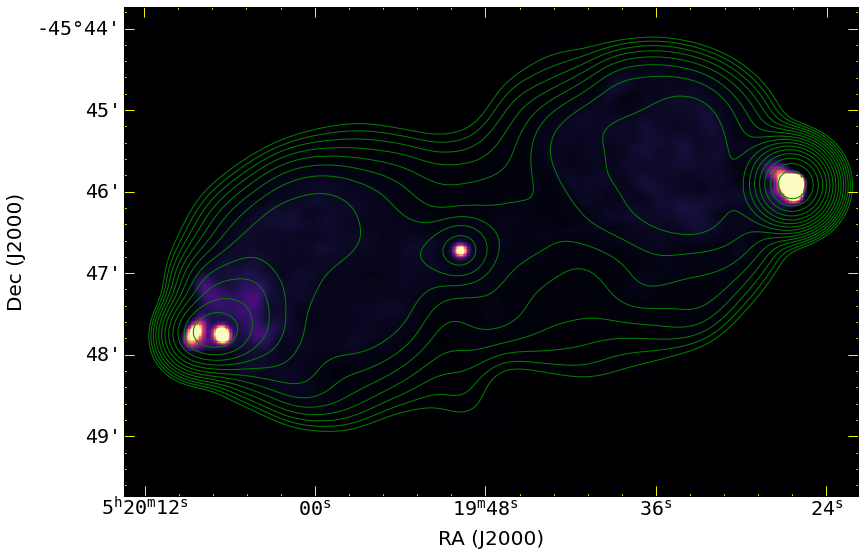

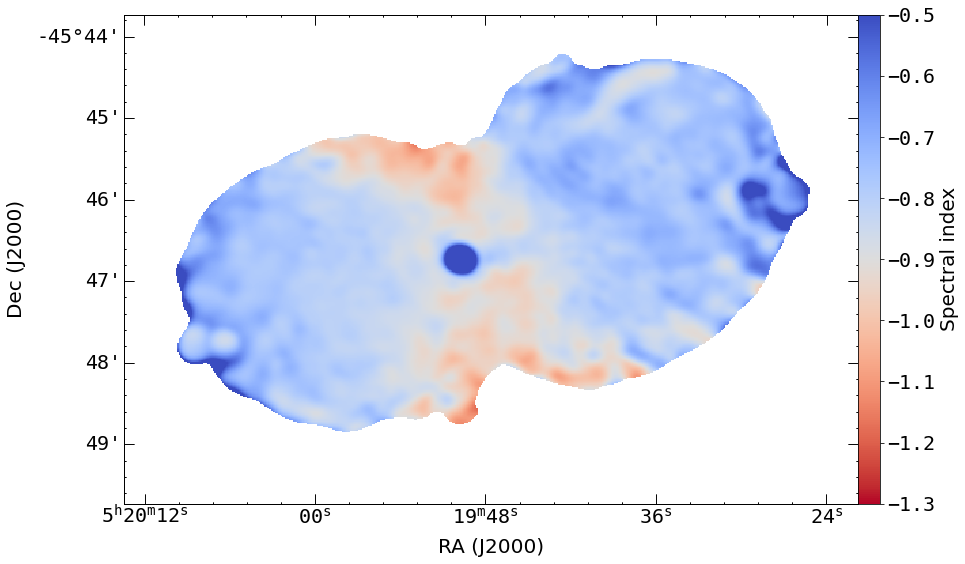

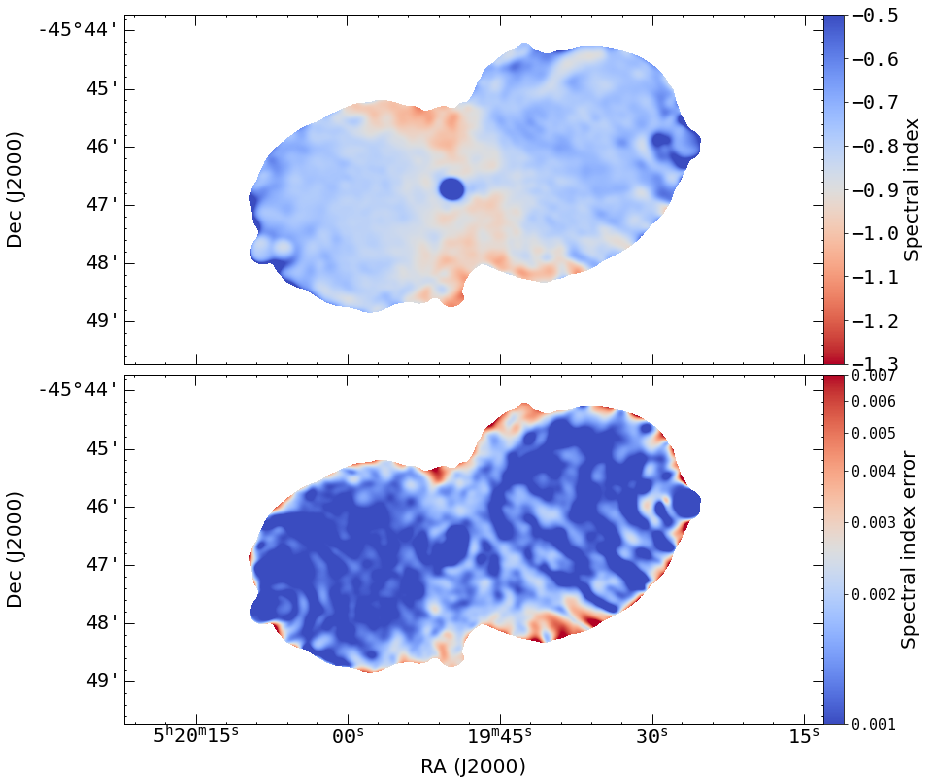

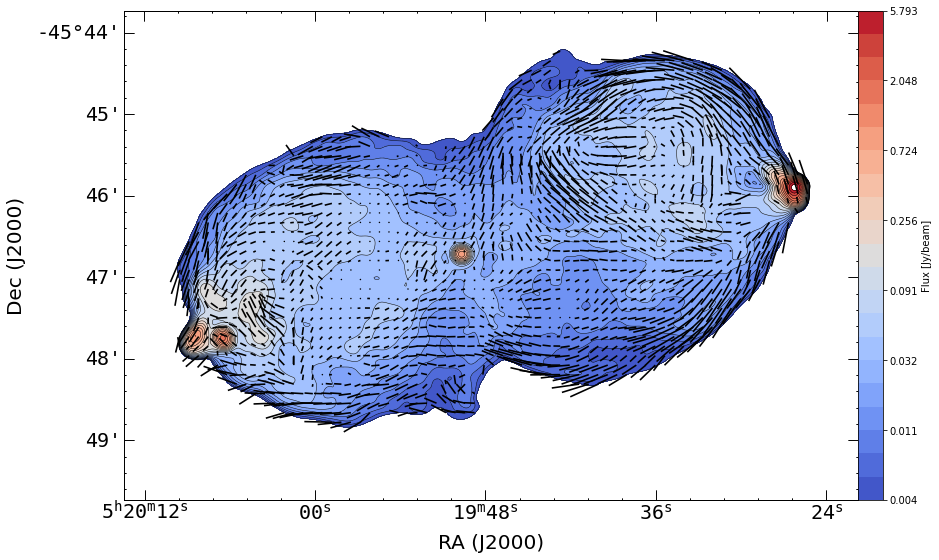

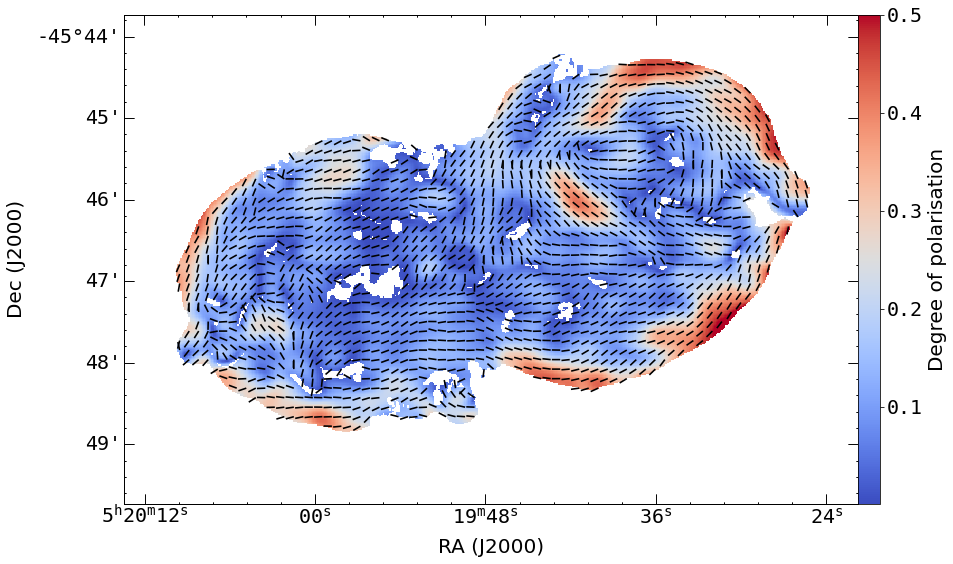

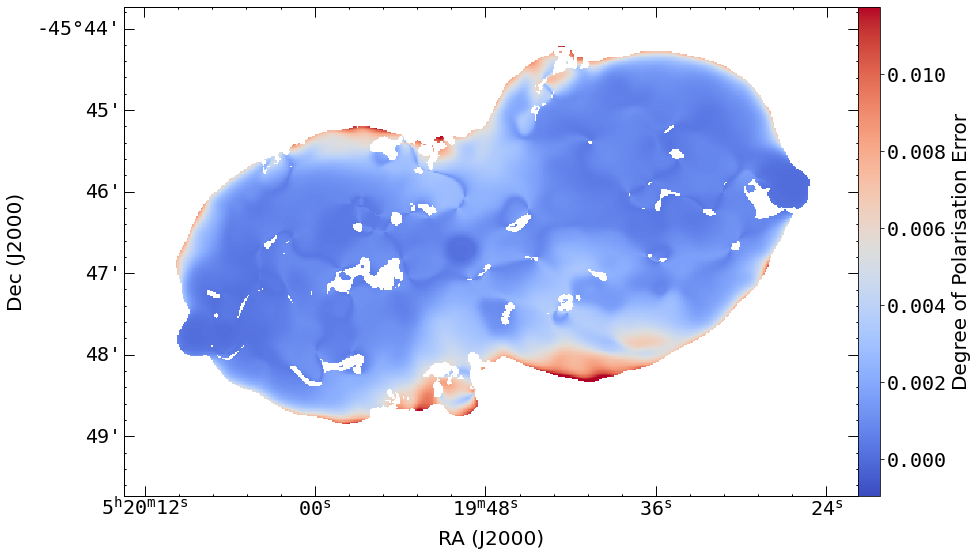

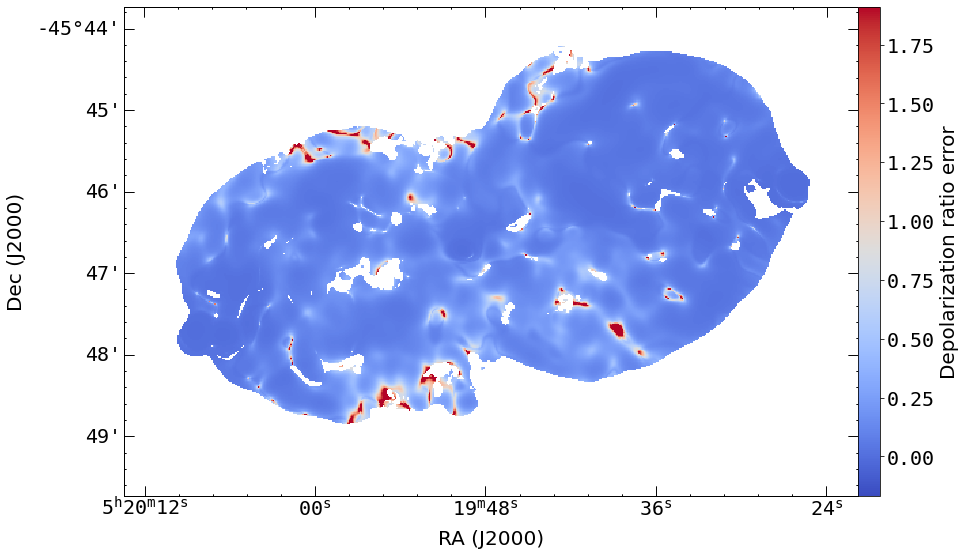

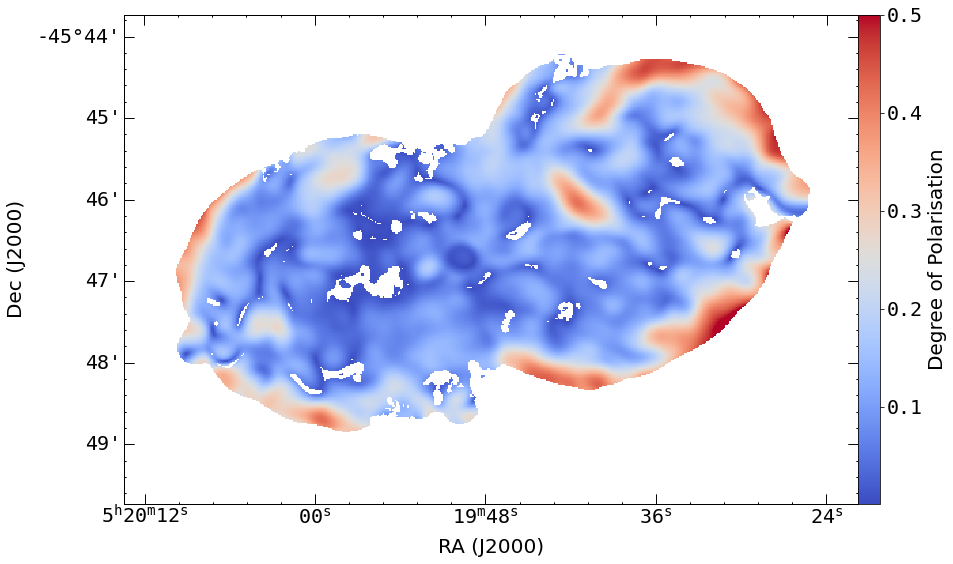

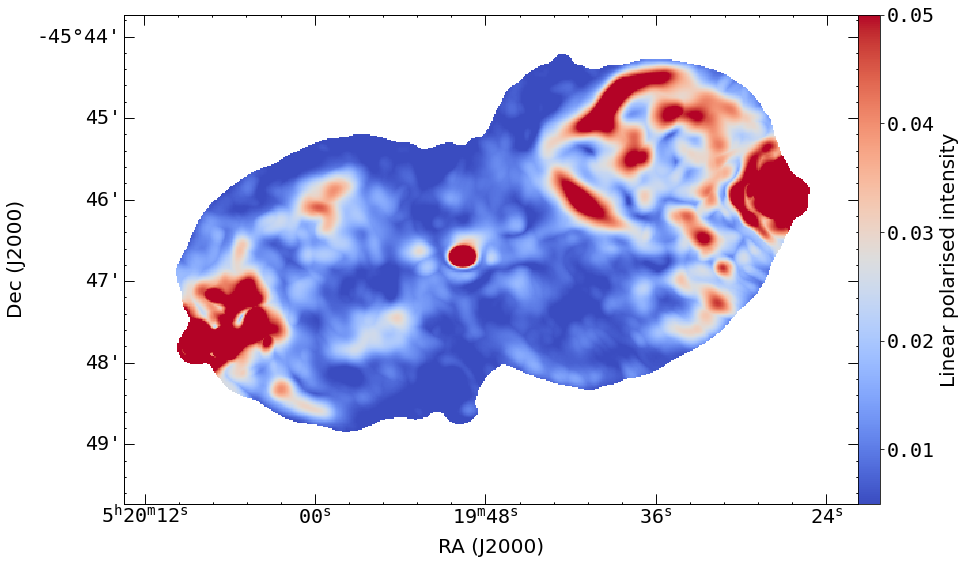

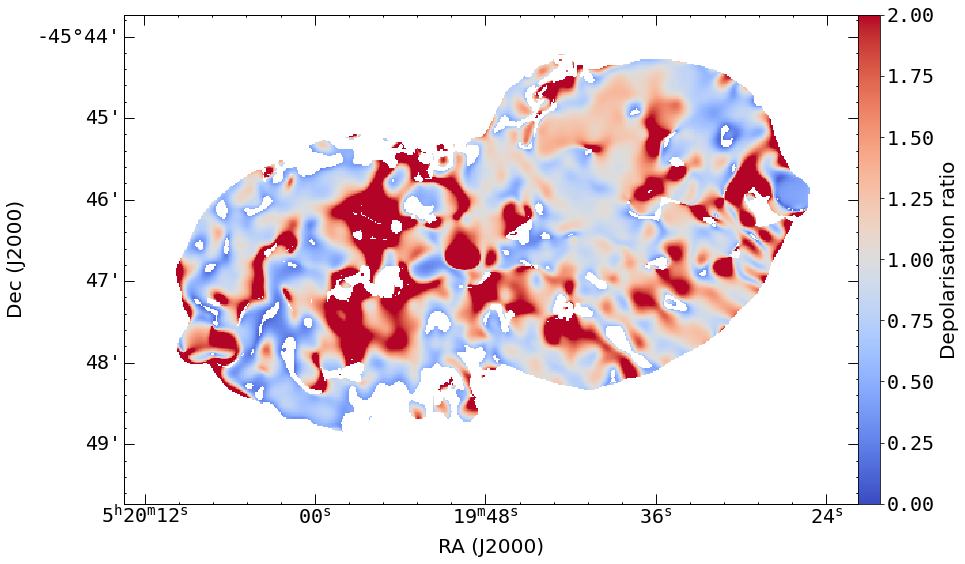

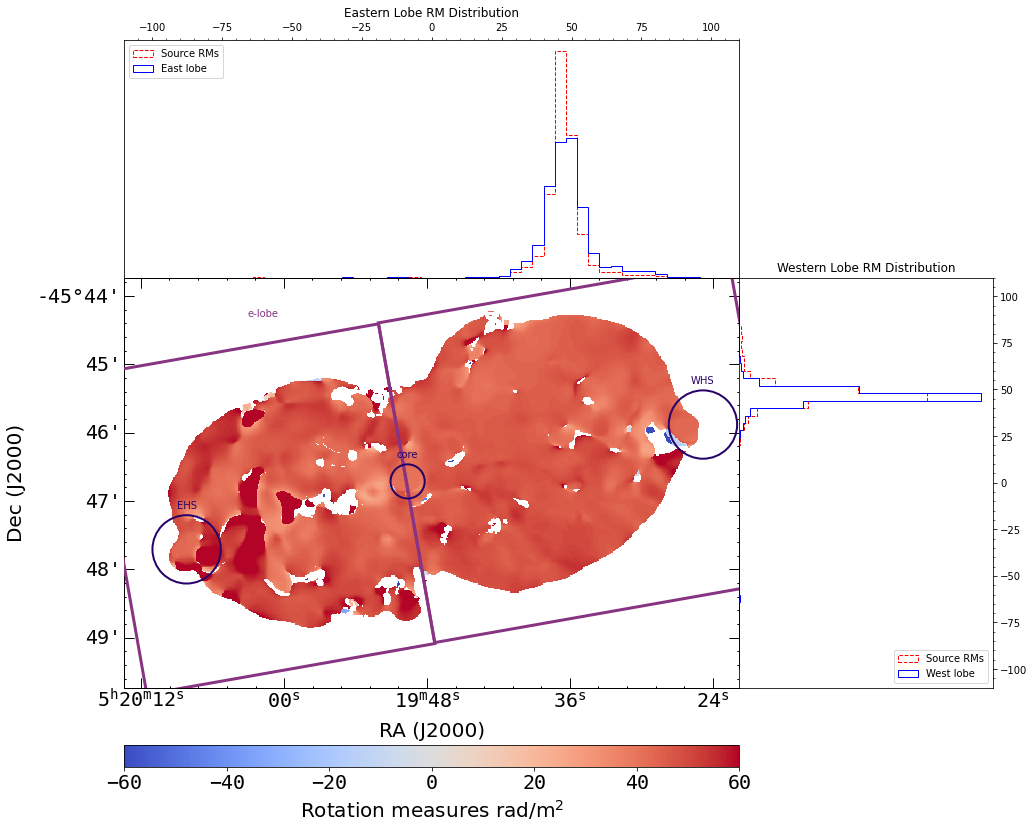

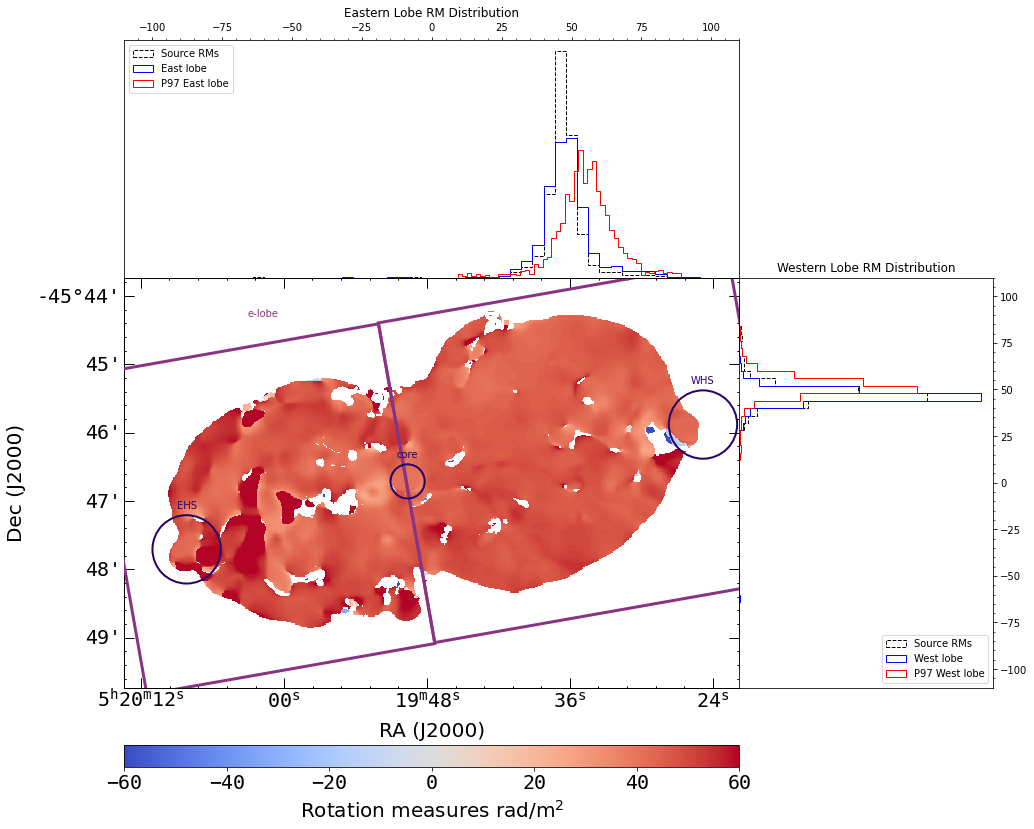

In [29]:
run_papermill()

os.system("rm casa*.log")


In [ ]:
    # pub = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-data/*.npz"))
    # pub_rm = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-rm-data/*.npz"))
    # lw=2
    # ms=8
    # with plt.style.context('seaborn-colorblind'):
    #     los, los_rm = list(zip(pub, pub_rm))[-2]
    #     fig, ax = plt.subplots(figsize=(4, 3), nrows=1, ncols=1, squeeze=True)
    #     plot_data = dict()
    #     plot_data.update(read_npz(los))
    #     plot_data.update(read_npz(los_rm))
        
    #     ax.errorbar(plot_data["lambda_sq"], plot_data["fpol"],
    #         yerr=plot_data["fpol_err"], fmt='o', ecolor="red", markersize=ms, alpha=0.5)
    #     ax.set_xlabel('$\lambda^2$ [m$^{2}$]', fontsize=13)
    #     # ax.set_ylabel('Fractional Pol', fontsize=13)
    #     ax.set_ylabel(r'p ($\lambda^{2}$)', fontsize=13)


    #     fig.tight_layout()

In [89]:
## Plotting some lines of sight with spectra
def lambda_to_faraday(lambda_sq, phi_range, lpol):
    N = len(lambda_sq)

    # get the initial lambda square value from the mean
    init_lambda_sq = lambda_sq.mean()
    fdata = np.zeros([len(phi_range)], dtype=complex)
    

    # for each phi, calculate the depth
    # we're getting the rm spectrum per depth
    for k, phi in enumerate(phi_range):
        try:
            fdata[k] = pow(N, -1) * np.nansum(
                lpol * np.exp(-2j * (lambda_sq-init_lambda_sq) * phi)
                )
        except ZeroDivisionError:
            continue
    return fdata


def rmtf_peak(lam2, phi_range, rmtf, fclean):
    """Shift and scale the rmtf"""
    # from the RM_SYNTHESIS.py SCRIPT
    fwhm = (3.8/ abs(lam2[0]-lam2[-1]))
    # FWHM of a gaussian is sigma * ((8ln2)**0.5)
    sigma = (fwhm/2.35482)
    Gauss = np.exp(-0.5 * (phi_range/sigma)**2) 
    pad = abs(phi_range[-1]) * 2
    dpad = abs(phi_range[0]-phi_range[1])
    phi_pad = np.arange(-pad, pad, dpad)
    dshift = int(pad/(2.0 * dpad))

    # pad the rmtf so that it can be shifted
    rmtf = lambda_to_faraday(lam2, phi_pad, 1) 

    idx = np.argmax(fclean)
    dirac = np.zeros(len(phi_range))
    dirac[idx] = fclean.max()

    rmtf = signal.convolve(rmtf, dirac, mode='same')
    rmtf = rmtf[dshift:-dshift+1]
    return np.abs(rmtf)


def plotter(ax, fi, data, lw=2, ms=8, axis_labels=True):
    ax[fi, 0].errorbar(data["lambda_sq"], data["fpol"],
        yerr=data["fpol_err"], fmt='o', ecolor="red", markersize=ms, alpha=0.5)
    
    if axis_labels:
        ax[fi, 0].set_xlabel('$\lambda^2$ [m$^{2}$]', fontsize=13)
        # ax[fi, 0].set_ylabel('Fractional Pol', fontsize=13)
        ax[fi, 0].set_ylabel(r'p ($\lambda^{2}$)', fontsize=13)

    
    data["pangle"] = np.unwrap(data["pangle"], period=np.pi, discont=np.pi/2)
    # linear fitting
    res = np.ma.polyfit(data["lambda_sq"], data["pangle"], deg=1)
    reg_line = np.poly1d(res)(data["lambda_sq"])
    
    # ax[fi, 1].plot(data["lambda_sq"], data["pangle"], "r+", label="original")
    ax[fi, 1].errorbar(data["lambda_sq"], data["pangle"],
        yerr=data["pangle_err"], fmt='o', ecolor="red",
        # label="Angle", 
        markersize=ms, alpha=0.5)
    ax[fi, 1].plot(data["lambda_sq"], reg_line, "g--", 
        label=f"fit slope: {res[0]:.3f}", lw=lw)
    
    if axis_labels:
        ax[fi, 1].set_xlabel('$\lambda^2$ [m$^{-2}$]', fontsize=13)
        # ax[fi, 1].set_ylabel('Pol Angle [rad]', fontsize=13)
        ax[fi, 1].set_ylabel(r'$\chi$ [rad]', fontsize=13)

    ax[fi, 1].legend()


    fclean = np.abs(data["fclean"])
    rm_val = data["depths"][np.argmax(fclean)]

    # ax[fi, 2].plot(data["depths"], np.abs(data["fdirty"]),
    #     'r--', label='Dirty')

    shifted = rmtf_peak(data["lambda_sq"], data["depths"], data["rmtf"], fclean)

    ax[fi, 2].plot(data["depths"], shifted,
        'r--', label='| RMTF |')
    
    if "fclean" in data:
        ax[fi, 2].plot(data["depths"], fclean, 'k',
            label=r"RM = "+f"{rm_val:.2f}")
        # ax[fi, 2].axvline(rm_val, label=f"{rm_val:.3f}")
    # ax[fi, 2].set_xlabel(r'Faraday depth ($\phi$)', fontsize=13)
    if axis_labels:
        ax[fi, 2].set_xlabel(r'$\phi$ [rad m$^{-2}$]', fontsize=13)
        # ax[fi, 2].set_ylabel('Faraday spectrum', fontsize=13)
        ax[fi, 2].set_ylabel(r'F ($\phi$)', fontsize=13)
    ax[fi, 2].legend()

    ax[fi, 2].tick_params(axis="both", direction="in")

    return ax
    

def plot_single_peak_spectra():

    pub = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-data/*.npz"))
    pub_rm = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-rm-data/*.npz"))

    plt.close("all")



    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(figsize=(14, 16), sharex="col", nrows=len(pub), ncols=3,
            gridspec_kw=dict(hspace=0))

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        print(los)
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, idx, plot_data, axis_labels=False)
        if idx == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")

    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-single-peak-ex{EXT}", dpi=DPI)


def plot_lowsnr_spectra():

    pub = sorted(
        glob("investigations/noisy/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/noisy/for-publication/los-rm-data/*.npz"))[:6]

    plt.close("all")



    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(figsize=(14, 16), sharex="col", nrows=len(pub), ncols=3,
        gridspec_kw=dict(hspace=0))

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, idx, plot_data, axis_labels=False)
        if idx == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")


    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-lowsnr-spectra-ex{EXT}", dpi=DPI)


def plot_interface_spectra():

    pub = sorted(
        glob("investigations/rm-patches/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/rm-patches/for-publication/los-rm-data/*.npz"))[:6]

    plt.close("all")


    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(figsize=(14, 16), sharex="col", nrows=len(pub), ncols=3,
        gridspec_kw=dict(hspace=0))

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, idx, plot_data, axis_labels=False)
        if idx == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")


    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-interface-spectra-ex{EXT}", dpi=DPI)


def plot_double_peaks_spectra():

    pub = sorted(
        glob("investigations/double-peaks/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/double-peaks/for-publication/los-rm-data/*.npz"))[:6]

    plt.close("all")

    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(figsize=(14, 16), sharex="col", nrows=len(pub), ncols=3, 
        gridspec_kw=dict(hspace=0)
        )

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, idx, plot_data, axis_labels=False)
        if idx == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")

        fclean = plot_data["fclean"]

        ax[idx, 2].plot(plot_data["depths"], fclean.real, 'b-.', label="Re(RMTF)")
        ax[idx, 2].plot(plot_data["depths"], fclean.imag, ':', label="Im(RMTF)", color="fuchsia")
        ax[idx, 2].legend(bbox_to_anchor=(1.5, 1))



    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-double-peaks-ex{EXT}", dpi=DPI)


def plot_weird_spectra():

    pub = sorted(
        glob("investigations/weird-doubles/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/weird-doubles/for-publication/los-rm-data/*.npz"))[:6]

    plt.close("all")


    with plt.style.context('seaborn-colorblind'):
        fig, ax = plt.subplots(figsize=(14, 16), sharex="col", nrows=len(pub), ncols=3, 
        gridspec_kw=dict(hspace=0)
        )

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, idx, plot_data, axis_labels=False)
        if idx == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")

        fclean = plot_data["fclean"]

        ax[idx, 2].plot(plot_data["depths"], fclean.real, 'b-.', label="Re(RMTF)")
        ax[idx, 2].plot(plot_data["depths"], fclean.imag, ':', label="Im(RMTF)", color="fuchsia")
        ax[idx, 2].legend(bbox_to_anchor=(1.5, 1))


    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-multiple-peaks-ex{EXT}", dpi=DPI)

# plot_single_peak_spectra()
# plot_lowsnr_spectra()
# # plot_interface_spectra()
# plot_double_peaks_spectra()
# plot_weird_spectra()

In [91]:
############3 LERATOS SUGGESTIONS############################

# Can you kindly generate a figure combining Fig 10, 11 and 12. For 
# Fig 10: use LoS shown in row 1, 2 and 7. 
# Fig 11: use row 3 and 6. 
# Fig 12 use 1,2 and 3. So it will be an image with 8 rows: 3 single peaks, 2 double and 3 multiple peaks. If 8 is a lot, remove one from single peaks.


def plot_single_peak_spectra_combi(ax, count=0):

    pub = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-data/*.npz"))
    pub_rm = sorted(glob(f"{products}/scrap-outputs-hi-SNR-s3/for-publication/los-rm-data/*.npz"))

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        if idx not in np.array([1,2, 7])-1:
            continue
        
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, count, plot_data, axis_labels=False)
        
        if count == 0:
            ax[0,0].set_title(r"p$(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,1].set_title(r"$\chi(\lambda^2)$", fontsize=15, font="monospace")
            ax[0,2].set_title(r"F$(\phi)$", fontsize=15, font="monospace")
        ax[count, 2].legend(bbox_to_anchor=(1.5, 1))

        count += 1
    return ax, count



def plot_double_peaks_spectra_combi(ax, count=0):

    pub = sorted(
        glob("investigations/double-peaks/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/double-peaks/for-publication/los-rm-data/*.npz"))[:6]

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        if idx not in np.array([3, 6])-1:
            continue
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, count, plot_data, axis_labels=False)

        fclean = plot_data["fclean"]

        ax[count, 2].plot(plot_data["depths"], fclean.real, 'b-.', label="Re(RMTF)")
        ax[count, 2].plot(plot_data["depths"], fclean.imag, ':', label="Im(RMTF)", color="fuchsia")
        ax[count, 2].legend(bbox_to_anchor=(1.5, 1))

        count += 1
    
    return ax, count



def plot_weird_spectra_combi(ax, count=0):

    pub = sorted(
        glob("investigations/weird-doubles/for-publication/los-data/*.npz"))[:6]
    pub_rm = sorted(
        glob("investigations/weird-doubles/for-publication/los-rm-data/*.npz"))[:6]

    plt.close("all")

    for idx, (los, los_rm) in enumerate(zip(pub, pub_rm)):
        if idx not in np.array([1,2,3])-1:
            continue
    
        plot_data = dict()
        plot_data.update(read_npz(los))
        plot_data.update(read_npz(los_rm))
        
        ax = plotter(ax, count, plot_data, axis_labels=False)

        fclean = plot_data["fclean"]

        ax[count, 2].plot(plot_data["depths"], fclean.real, 'b-.', label="Re(RMTF)")
        ax[count, 2].plot(plot_data["depths"], fclean.imag, ':', label="Im(RMTF)", color="fuchsia")
        ax[count, 2].legend(bbox_to_anchor=(1.5, 1))
        count += 1
    
    return ax, count

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(14, 18), sharex='col', nrows=8, ncols=3 ,gridspec_kw=dict(hspace=0))
    ax, idx = plot_single_peak_spectra_combi(ax)
    ax, idx = plot_double_peaks_spectra_combi(ax, idx)
    ax, idx = plot_weird_spectra_combi(ax, idx)
    fig.tight_layout()
    fig.savefig(f"{PFIGS}/sample-combined-ex{EXT}", dpi=DPI)

In [13]:
# 37 39 48 54 57 58 60 61 63 64 74 77 78 82 88 94 98 99 100

# 5 - single, 6/10/19/28- double, 37/56 - double close, 72 - interesting
# 5,6,10,19,28,37,56,72
def make_simulated_data_stuff():
    # f - flagged
    # uf - unflagged
    model_f, model_uf, model_f2, model_uf2, real_f, real_uf, real_f2, real_uf2 = [], [], [], [], [], [], [], []
    
    # for the 
    p01, p02 = [], []
    odir_main = "investigations/missing-effects/sim-data/two"
    n_los = 100
    # because errors are the same for all the lines of sight
    i_err = np.zeros((1, 80))
    q_err = np.zeros((1, 80))
    u_err = np.zeros((1, 80))
    for i in range(1, n_los+1):

        flagged_model = f"{odir_main}/qu-fits-f-dual/qufit-reg_{i}-fitparameters.txt"
        unflagged_model = f"{odir_main}/qu-fits-nf-dual/qufit-reg_{i}-fitparameters.txt"

        actual_f = f"{odir_main}/los-data-f/reg_{i}.npz" 
        actual_nf = f"{odir_main}/los-data-nf/reg_{i}.npz"

        # flagged and unflagged model RM 1
        model_f.append(np.loadtxt(flagged_model)[2])
        model_uf.append(np.loadtxt(unflagged_model)[2])

        # flagged and unflagged model RM 2
        model_f2.append(np.loadtxt(flagged_model)[6])
        model_uf2.append(np.loadtxt(unflagged_model)[6])

        # flagged and unflagged actual sim data RM 1
        real_f.append(np.load(actual_f)["in_rm"])
        real_uf.append(np.load(actual_nf)["in_rm"])

        # flagged and unflagged actual sim data RM 2
        real_f2.append(np.load(actual_f)["in_rm2"])
        real_uf2.append(np.load(actual_nf)["in_rm2"])

        # p0 and p1 values
        p01.append(np.load(actual_nf)["in_p0"])
        p02.append(np.load(actual_nf)["in_p02"])

        
    i_err[0] = np.load(actual_nf)["I_err"]
    q_err[0] = np.load(actual_nf)["Q_err"]
    u_err[0] = np.load(actual_nf)["U_err"]

    # model rm1 and 2
    model_f = np.array(model_f)
    model_uf = np.array(model_uf)
    model_f2 = np.array(model_f2)
    model_uf2 = np.array(model_uf2)

    # simulateed rm 1 and 2
    real_f = np.array(real_f)
    real_uf = np.array(real_uf)
    real_f2 = np.array(real_f2)
    real_uf2 = np.array(real_uf2)

    p01 = np.array(p01)
    p02 = np.array(p02)


    return model_f,model_uf,model_f2,model_uf2,real_f,real_uf,real_f2,real_uf2, p01, p02, i_err, q_err,u_err


def plot_rm_spacing():
    loss = range(1, 101)
    with plt.style.context('seaborn-colorblind'):    
        fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
        diff = abs(real_uf - real_uf2)
        ax[0].hist(diff, bins=10, fill=False, lw=3, edgecolor="k",density=False,
            linestyle="-", histtype="stepfilled")
        ax[0].set_xlabel(r"RM spacing $( |\phi_{0} - \phi_{1} | )$", fontsize=20,
            font="monospace")
        # ax[0].set_ylabel("Counts", fontsize=20, font="monospace")
        ax[0].tick_params(labelleft=False, left=False, labelsize=20)
        # ax.tick_params(axis="y", which="both", left=False, labelleft=False)

        ax[1].plot(loss, diff, "ko-", alpha=1, lw=2, label=r"$( |\phi_{0} - \phi_{1} | )$")
        ax[1].plot(loss, real_uf, "x--", color="blue", alpha=1, lw=2, markersize=10, label=r"$\phi_{0}$")
        ax[1].plot(loss, real_uf2, "+-", color="orangered", alpha=1, lw=2, markersize=10, label=r"$\phi_{1}$")
        ax[1].set_xlabel("Regions",  fontsize=20, font="monospace")
        ax[1].set_ylabel(r"[rad/m$^{2}$]",  fontsize=20, font="monospace")
        ax[1].minorticks_on()
        ax[1].legend(loc="upper right", bbox_to_anchor=(1, 1.1), ncol=3, fontsize=20, markerscale=3)
        ax[1].set_xticks(np.arange(0, 101, 10))
        ax[1].tick_params(labelsize=20)
        plt.grid(visible=True, which="both", axis="x")
        plt.grid(visible=True, which="major", axis="x", lw=2)
        plt.grid(visible=True, which="both", axis="y")
        plt.grid(visible=True, which="major", axis="y", lw=2)
        fig.tight_layout()
        fig.savefig(f"{PFIGS}/exp-missing-chan-rm-spacing{EXT}", dpi=DPI)

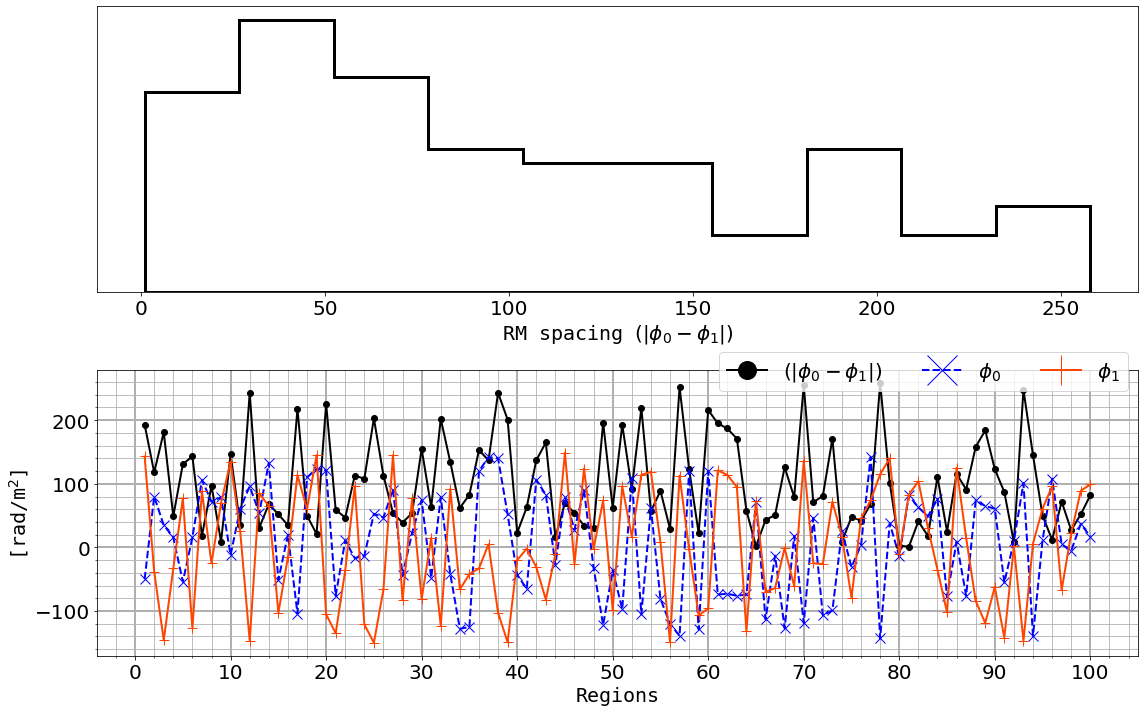

In [14]:
(model_f,model_uf,model_f2,model_uf2,
real_f,real_uf,real_f2,real_uf2, p01, p02, i_err, q_err,u_err) = make_simulated_data_stuff()

plot_rm_spacing()


# print("For the flagged data")
# print("-"*35)
# for ix, (a, a2, b, b2) in enumerate( zip(real_f, real_f2,  model_f, model_f2), start=1):
#     print(f"{ix} . Sim1: {a:10.2f} | Sim2 {a2:10.2f}")
#     print(f"{ix} . Mod1: {b:10.2f} | Mod2: {b2:10.2f}")
#     print("-"*20)

# print("="*35)
# print("For the unflagged data")
# print("="*35)
# for ix, (a, a2, b, b2) in enumerate(zip(real_uf, real_uf2,  model_uf, model_uf2), start=1):
#     print(f"{ix} . Sim1: {a:10.2f} | Sim2 {a2:10.2f}")
#     print(f"{ix} . Mod1: {b:10.2f} | Mod2: {b2:10.2f}")
#     print("-"*20)

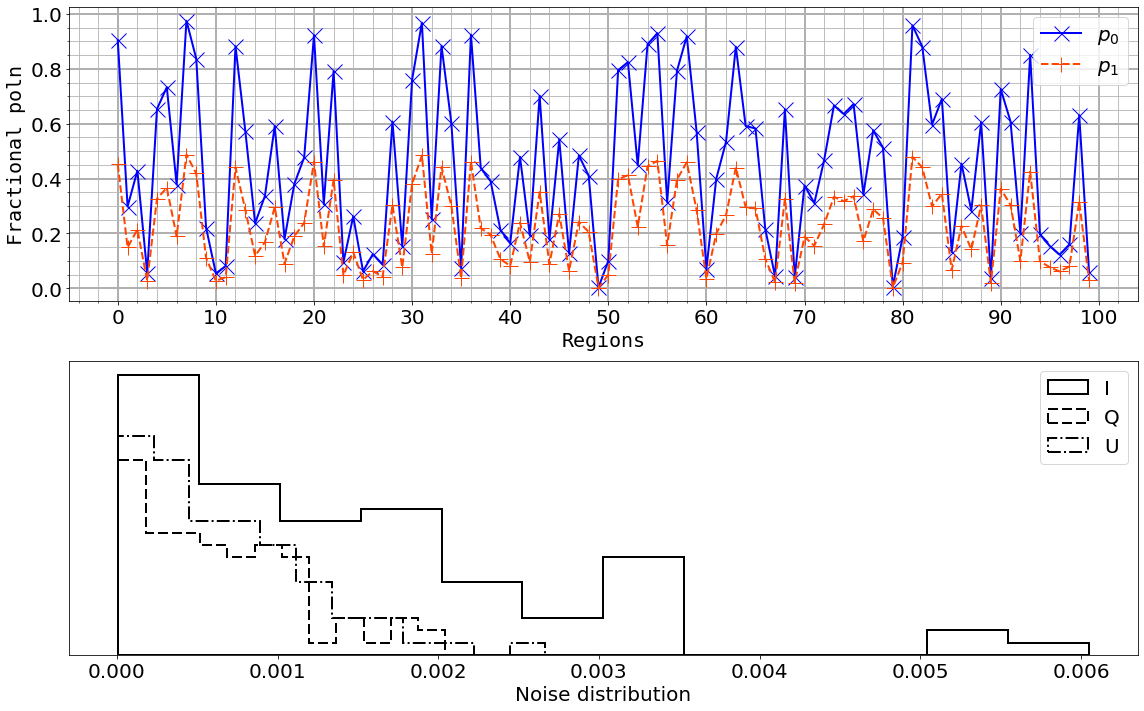

In [15]:
def plot_p1_p2_distribution():
    plt.close("all")
    loss = range(1, 101)
    fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
    ax[0].plot(p01, "-x" , lw=2, markersize=15, alpha=1, label=r"$p_{0}$", color="blue")
    ax[0].plot(p02, "--+" , lw=2, markersize=15, alpha=1,label=r"$p_{1}$", color="orangered")

    ax[0].set_ylabel(r"Fractional poln", fontsize=20, font="monospace")
    ax[0].set_xlabel("Regions", fontsize=20, font="monospace")
    ax[0].legend(fontsize=20)

    ax[0].minorticks_on()
    ax[0].set_xticks(np.arange(0, 101, 10))
    ax[0].tick_params(labelsize=20)

    ax[0].grid(visible=True, which="both", axis="x")
    ax[0].grid(visible=True, which="major", axis="x", lw=2)
    ax[0].grid(visible=True, which="both", axis="y")
    ax[0].grid(visible=True, which="major", axis="y", lw=2)


    al = 1
    lw = 2
    specs = dict(bins=12, alpha=al, fill=False, lw=lw, histtype="stepfilled", color="k")
    ax[1].hist(i_err[0,:], **specs, ls="-", label="I")
    ax[1].hist(q_err[0,:], **specs, ls=(0, (5, 2)), label="Q")
    ax[1].hist(u_err[0,:], **specs, ls="dashdot", label="U")
    ax[1].set_xlabel("Noise distribution", fontsize=20)
    ax[1].tick_params(labelleft=False, left=False, labelsize=20)
    ax[1].legend(fontsize=20)

    fig.tight_layout()
    fig.savefig(f"{PFIGS}/p1-p2-distribution{EXT}", dpi=DPI)
    return

plot_p1_p2_distribution()


In [ ]:
# def plot_p1_p2_distribution_x2():
#     plt.close("all")
#     loss = range(1, 101)
#     fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
#     ax.hist(p01, bins=20, fill=False, lw=3, edgecolor="blue",density=False,
#     orientation="vertical",
#         linestyle="-", histtype="stepfilled", label="p1")
#     ax.hist(p02, bins=20, fill=False, lw=3, edgecolor="red",density=False,
#     orientation="vertical",
#         linestyle="-", histtype="stepfilled", label="p2")
#     ax.legend()
#     fig.tight_layout()
  
#     return

# # plot_p1_p2_distribution_x2()


investigations/missing-effects/sim-data/two/pubs/qu-fits-f-dual/qufit-reg_31-plot-dat.npz
investigations/missing-effects/sim-data/two/pubs/qu-fits-f-dual/qufit-reg_17-plot-dat.npz
investigations/missing-effects/sim-data/two/pubs/qu-fits-f-dual/qufit-reg_15-plot-dat.npz


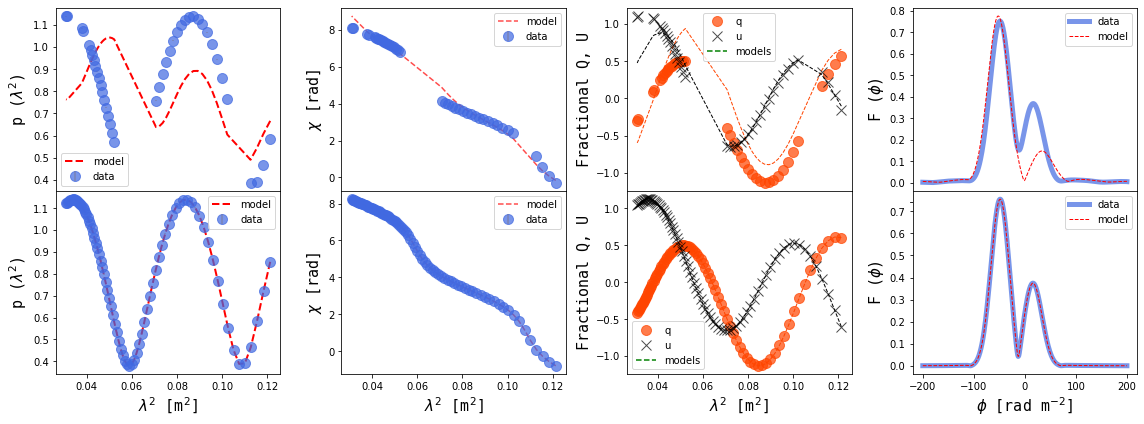

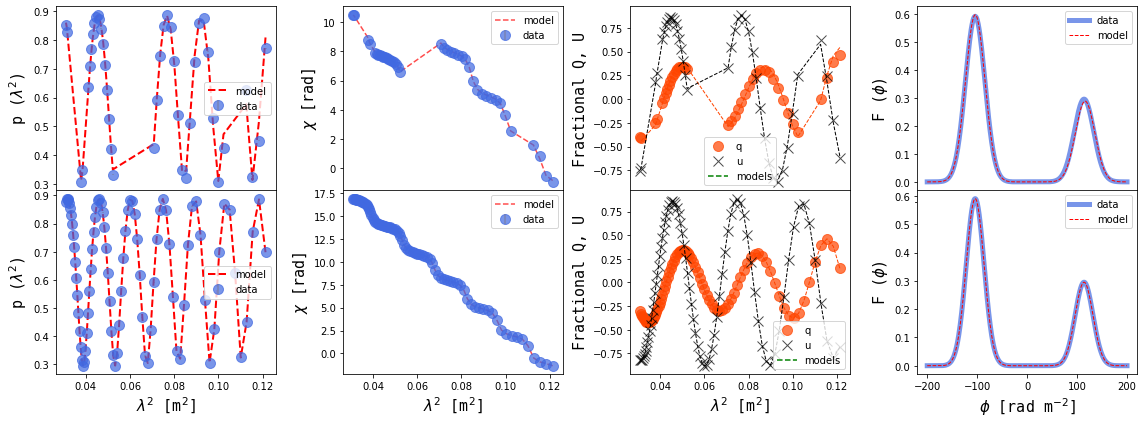

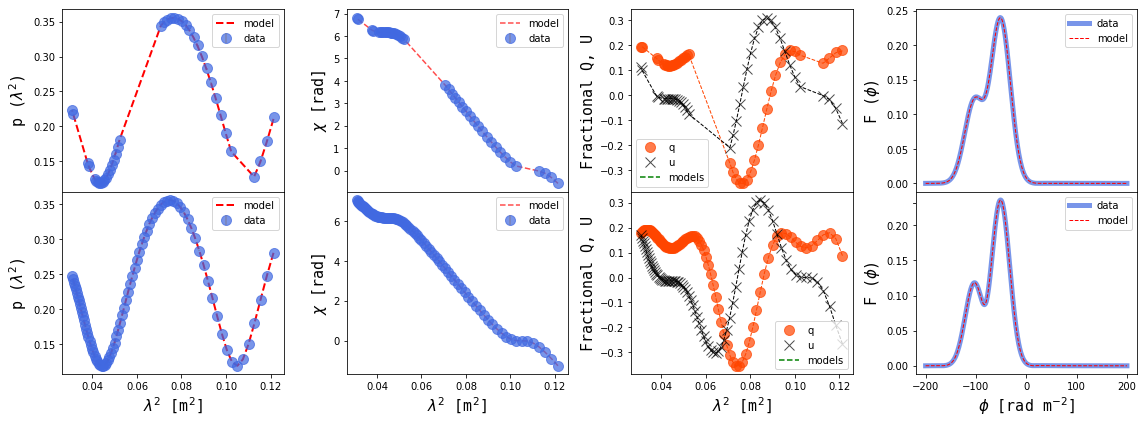

In [11]:
import itertools as it
def plot_qufit(ax, row, x, qdata, udata, umodel, qmodel, fdata, fmodel, phi_range, sigmaPA, sigmap):
    ms = 10
    alpha = 0.7
    pdata = qdata + 1j * udata   
    pmodel = qmodel + 1j * umodel
      
    angle_data = np.arctan2(udata, qdata)
    angle_model = np.arctan2(umodel, qmodel)

    ind = np.where(abs(fdata) == max(abs(fdata)))[0]
    rm = phi_range[ind]
    # angle_data = remove_ambiguity(angle_data, rm)
    # angle_model = remove_ambiguity(angle_model, rm)
    angle_data = np.unwrap(angle_data)
    angle_model = np.unwrap(angle_model)

    legs = dict(loc='best')

    ax[row, 0].errorbar(x, np.abs(pdata), yerr=sigmap, fmt='o', 
        color="royalblue", ms=ms, ecolor='orange', alpha=alpha, label='data')
    ax[row, 0].plot(x, np.abs(pmodel), 'r--', lw=2, label='model')
    ax[row, 0].set_ylabel(r'p ($\lambda^{2}$)', font="monospace", fontsize=15)
    ax[row, 0].set_xlabel('$\lambda^2$ [m$^{2}$]', font="monospace", fontsize=15)
    ax[row, 0].legend(**legs)
            
    ax[row, 1].errorbar(x, angle_data, yerr=sigmaPA, fmt='o',
        ecolor='orange', ms=ms, alpha=alpha, color="royalblue", label="data")
    ax[row, 1].plot(x, angle_model, 'r--', ms=ms, alpha=alpha, label="model")
    ax[row, 1].set_ylabel(r'$\chi$ [rad]', font="monospace", fontsize=15)
    ax[row, 1].set_xlabel(r'$\lambda^2$ [m$^{2}$]', font="monospace", fontsize=15)
    ax[row, 1].legend(**legs)

    ax[row, 2].plot(x, qdata, 'o', label='q', ms=ms, color="orangered", alpha=alpha)
    ax[row, 2].plot(x, qmodel, '--', lw=1, color="orangered")
    ax[row, 2].plot(x, udata, 'kx', label='u', ms=ms, alpha=alpha)
    ax[row, 2].plot(x, umodel, 'k--', lw=1,)
    ax[row, 2].plot(x[0],qdata[0], "g--", label="models")
    ax[row, 2].set_xlabel('$\lambda^2$ [m$^{2}$]', font="monospace", fontsize=15)
    ax[row, 2].set_ylabel("Fractional Q, U", font="monospace", fontsize=15)
    ax[row, 2].legend(**legs)


    ax[row, 3].plot(phi_range, np.abs(fdata), label="data", lw=5, color="royalblue", alpha=alpha)
    ax[row, 3].plot(phi_range, np.abs(fmodel), 'r--', label='model', lw=1)
    ax[row, 3].set_ylabel('F ($\phi$)', font="monospace", fontsize=15)
    ax[row, 3].set_xlabel('$\phi$ [rad m$^{-2}$]', font="monospace", fontsize=15)
    ax[row, 3].legend(**legs)

    return ax



fits_f = glob("investigations/missing-effects/sim-data/two/pubs/qu-fits-f-dual/qufit-*plot-dat.npz")
fits_uf = glob("investigations/missing-effects/sim-data/two/pubs/qu-fits-nf-dual/qufit-*plot-dat.npz")

items = list(it.chain.from_iterable(zip(fits_f, fits_uf)))
exms = mkdir(f"{PFIGS}/missing")
with plt.style.context('seaborn-colorblind'):

    # -------------------------------------------
    # put all the examples in one plot
    # -------------------------------------------
    # fig, ax = plt.subplots(nrows=len(items), ncols=4, figsize=(16, 16))
    # for i, filef in enumerate(items):
    #     # plot singles
    #     test_f = read_npz(filef)
    #     ax = plot_qufit(ax=ax, row=i, **test_f)
    # fig.tight_layout()
    # fig.savefig(f"{exms}/missing-freq-all-exs.{EXT}", dpi=DPI)
    
    # ===========================================


    # -------------------------------------------
    # plot flagged and unflagged on the same plot 
    # double double plot
    # -------------------------------------------
    for i, (a, b) in enumerate(zip(fits_f, fits_uf)):
        # plot singles
        print(a)
        reg = os.path.basename(a).split("-")[1].split("_")[-1]
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6),gridspec_kw=dict(hspace=0))
        test_f = read_npz(a)
        test_uf = read_npz(b)
        ax = plot_qufit(ax=ax, row=0, **test_f)
        ax = plot_qufit(ax=ax, row=1, **test_uf)
        # fig.suptitle(f"Region {reg}")
        fig.tight_layout()
        fig.savefig(f"{exms}/mis-{i}{EXT}", dpi=DPI)

    # #  stack them
    # # fig, ax = plt.subplots(nrows=len(fits_f))
    # # for i in range(len(fits_f)):
    # #     plt.close("all")
    # #     ima = mpimg.imread(f"{exms}/mis-{i}{EXT}")
    # #     ax[i].set_axis_off()
    # #     ax[i].imshow(ima)
    # # fig.tight_layout()
    # # fig.savefig(f"{exms}/mis-stacked{EXT}", dpi=DPI)
    # # print("stacking done")

    # ===========================================

    

In [ ]:
# ! python qu_pol/scrappy/rmsynthesis/rm_synthesis.py -id investigations/investigate-double-peaks/for-publication/los-data/ -od investigations/investigate-double-peaks/for-publication/los-rm-data -md 400 --depth-step 1
# ln /home/andati/pica/reduction/experiments/emancipation/6-not-derotated-after-6-kunislope-t8-f64-iquv/00-polarimetry/investigations/investigate-double-peaks/for-publication/los-rm-data-plots/rmtf.pdf

# ! python /home/andati/git_repos/misc_scripts_n_tools/polarisation_stuff/compare-mods.py
# ln /home/andati/pica/reduction/experiments/emancipation/6-not-derotated-after-6-kunislope-t8-f64-iquv/00-polarimetry/investigations/investigate-double-peaks/dual-vs-single-comp-model-bf.pdf

In [16]:
def versuz(diro, mode):
    """
    Stack images together arbitrarily
    """

    mkpath = os.path.join

    vd = mkdir(f"{diro}/versuz")
    for reg in range(1, 101):
        plt.close("all")
        ima = mpimg.imread(f"{diro}/qu-fits-f-{mode}/qufit-reg_{reg}-MODEL.png")
        imb = mpimg.imread(f"{diro}/qu-fits-nf-{mode}/qufit-reg_{reg}-MODEL.png")
        # ima = mpimg.imread(f"{diro}/qu-fits-single/qufit-reg_{reg}-MODEL.png")
        # imb = mpimg.imread(f"{diro}/qu-fits-dual/qufit-reg_{reg}-MODEL.png")
        fig, ax = plt.subplots(figsize=(16, 9), ncols=2, nrows=1)
        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[0].imshow(ima)
        ax[1].imshow(imb)
        fig.tight_layout()
        # print(mkpath(vd, f"reg_{reg}{EXT}"))
        fig.savefig(mkpath(vd, f"reg_{reg}.png"))
        print(f"Reg {reg} Done")

# versuz(diro="investigations/missing-effects/sim-data/one", mode="single")
# versuz(diro="investigations/missing-effects/sim-data/two", mode="dual")

# versuz(diro="investigations/investigate-double-peaks/weirdo-s3/", mode="")

: 

In [193]:
def thesis_selfcal(toast, oname=None):

    fig = plt.figure(figsize=(16, 9))

    fig1 = FITSFigure(toast[0], figure=fig, subplot=[0, 0, 0.45, 1])

    vmax = 1e-2

    fig1 = basic_figure(fig1, vmin=0, vmax=vmax, cbar_loc=None, cmap="magma", tcolor="yellow")
    
    fig1.recenter(ra_deg, dec_deg, width=0.18, height=0.05)
   
       
    # fig1.colorbar.set_axis_label_text("Spectral index")
    # fig1.colorbar.set_axis_label_font(size=20, weight="normal")
    # fig1.colorbar.set_font(size=20, family="monospace")
    # fig1.ticks.hide_x()
    fig1.tick_labels.hide_y()
    fig1.axis_labels.hide_y()
    fig1.tick_labels.hide_x()
    fig1.axis_labels.hide_x()
    # fig1.add_colorbar(pad=0, location="bottom")

    xmin, ymin, dx, dy = fig1.ax.get_position().bounds
    
    fig2 = FITSFigure(toast[1], figure=fig, subplot=[0.46, -0.014, 0.45, 1.028])


    fig2 = basic_figure(fig2, vmin=0, vmax=vmax, cbar_loc=None, cmap="magma", tcolor="yellow")
    fig2.recenter(ra_deg, dec_deg, width=0.18, height=0.05)
   
    fig2.tick_labels.hide_y()
    fig2.axis_labels.hide_y()
    fig2.tick_labels.hide_x()
    fig2.axis_labels.hide_x()
    fig2.add_colorbar(pad=0, location="right")
    # fig2.colorbar.set_axis_label_text("Spectral index error")
    # fig2.show_colorscale(cmap="coolwarm",  vmin=1e-3, vmax=7e-3, stretch="log")
    # fig2.colorbar.set_axis_label_font(size=20, weight="normal")
    # fig2.colorbar.set_font(size=15, family="monospace")

    # fig1.set_nan_color("white")
    # fig2.set_nan_color("white")


    if oname is None:
        oname = f"thesis/{oname}.png"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=DPI, bbox_inches="tight")

sone = [
    "/home/andati/pica/reduction/experiments/final-cut/00-after-1gc/image-MFS-I-dirty.fits",
    "/home/andati/pica/reduction/experiments/final-cut/00-after-1gc/image-MFS-I-image.fits"]

stwo = [
    # "/home/andati/pica/reduction/experiments/final-cut/01-after-kunislope/image-MFS-I-dirty.fits",
    "/home/andati/pica/reduction/experiments/final-cut/00-after-1gc/image-MFS-I-image.fits",
    "/home/andati/pica/reduction/experiments/final-cut/01-after-kunislope/image-MFS-I-image.fits"]

sthree = [
    # "/home/andati/pica/reduction/experiments/final-cut/02-after-g/image-MFS-I-dirty.fits",
    "/home/andati/pica/reduction/experiments/final-cut/01-after-kunislope/image-MFS-I-image.fits",
    "/home/andati/pica/reduction/experiments/final-cut/02-after-g/image-MFS-I-image.fits"]

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]


thesis/s1
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
thesis/s2
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
thesis/s3


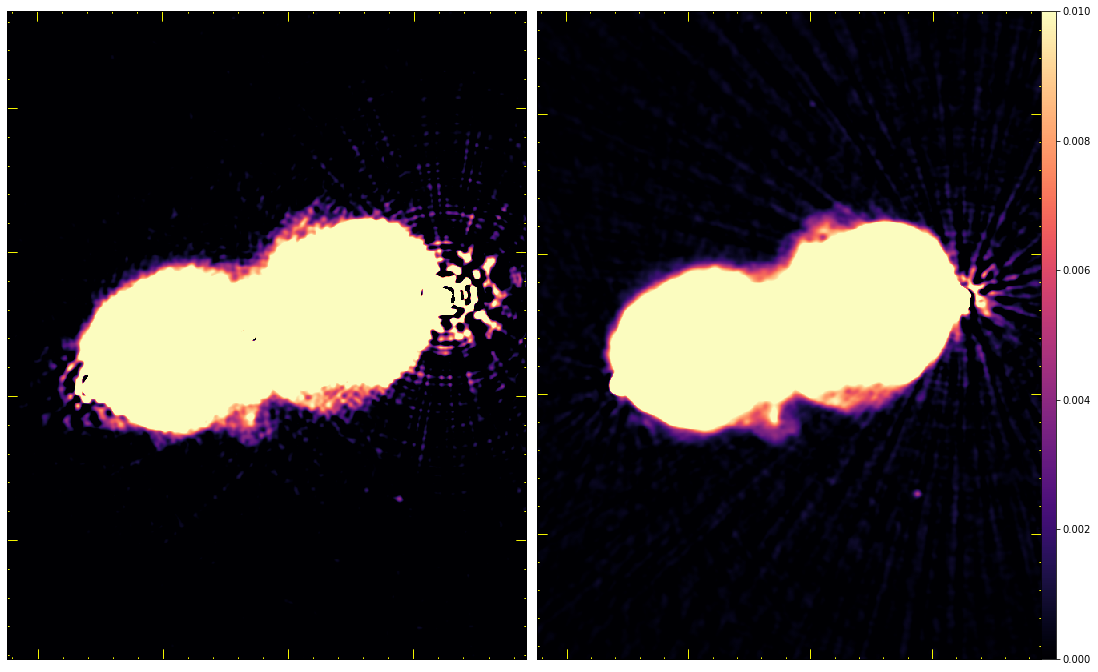

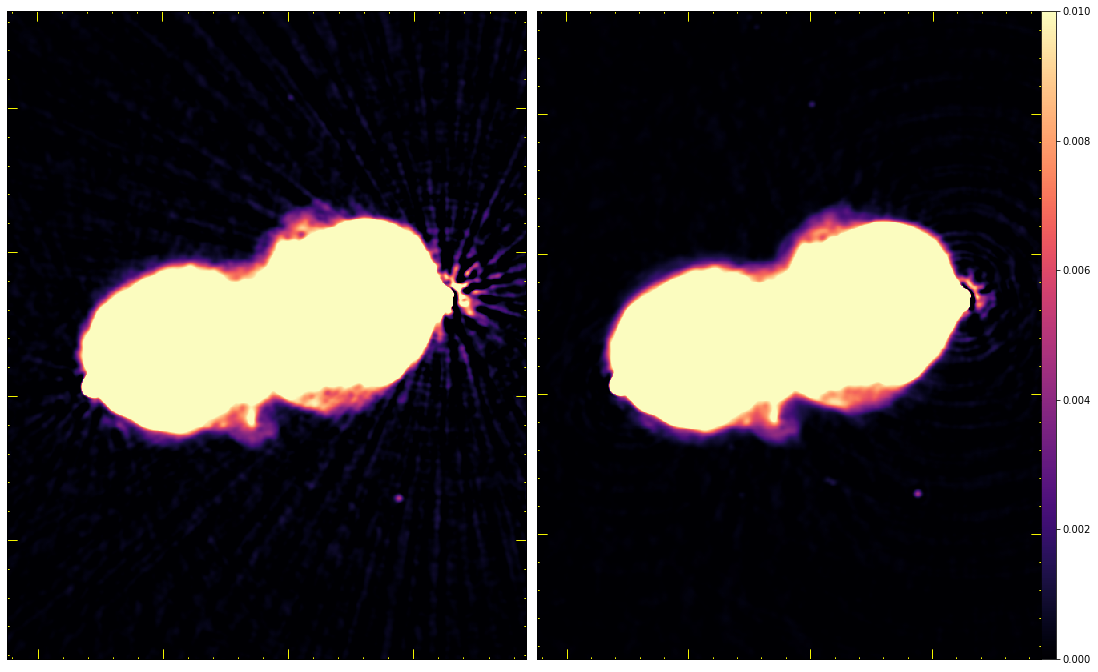

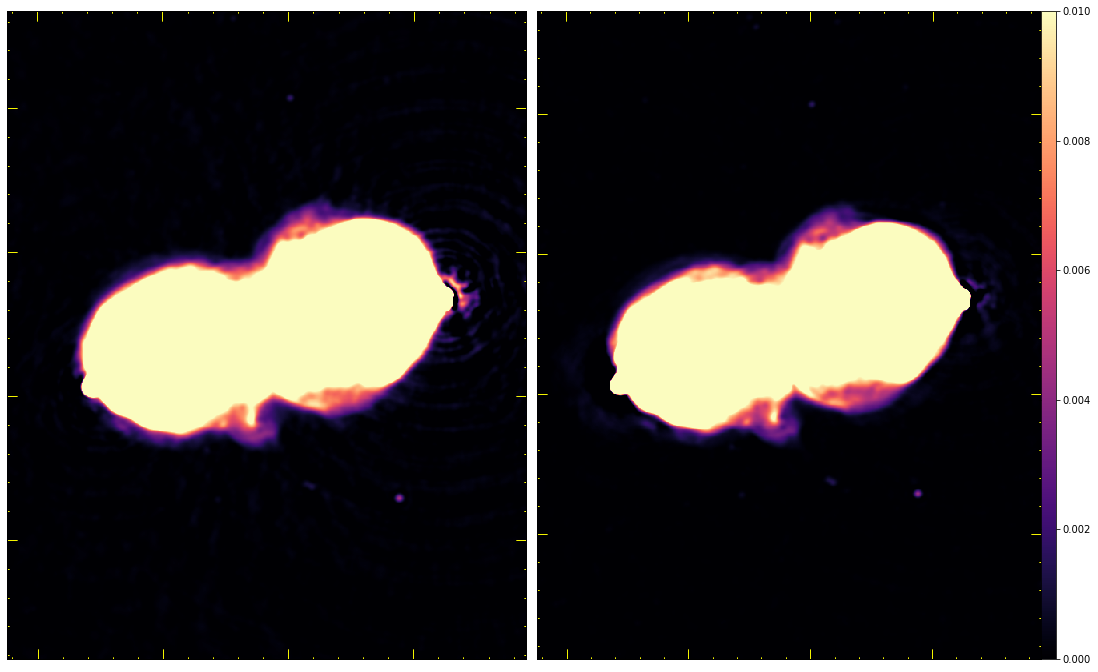

In [194]:

thesis_selfcal(sone, "thesis/selfcal-1")
thesis_selfcal(stwo, "thesis/selfcal-2")
thesis_selfcal(sthree, "thesis/selfcal-3")


INFO: Setting slices=[0, 0] [aplpy.core]
thesis/pica-nc.png


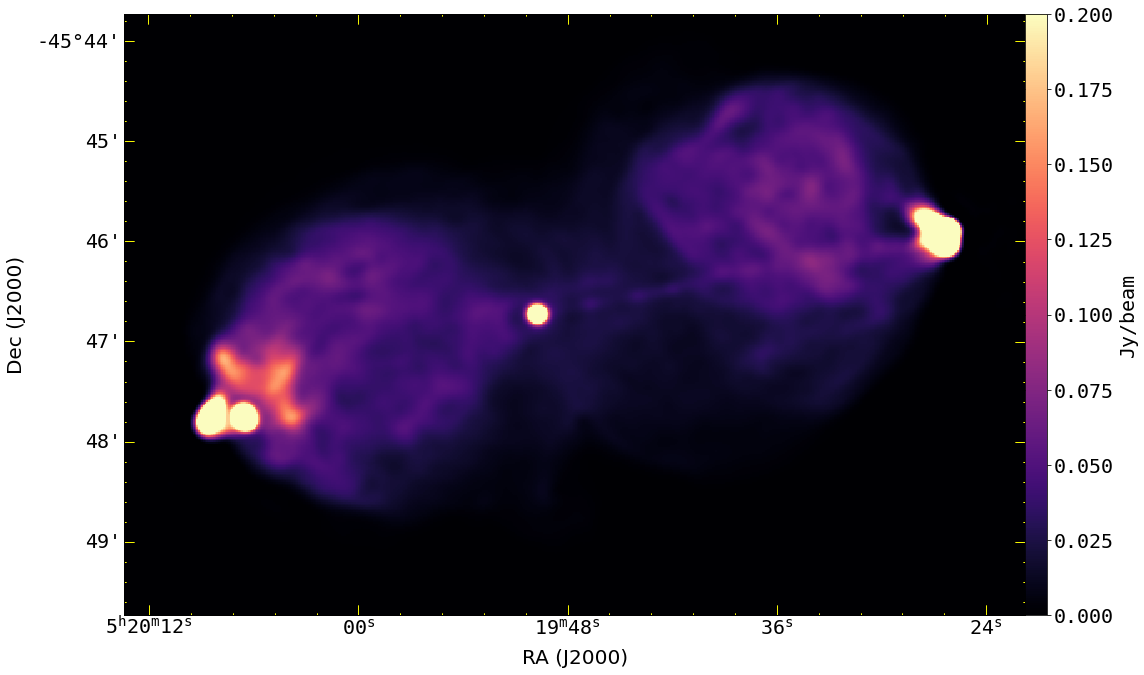

In [31]:
def thesis_pica(oname=None):
    # tes = "/home/andati/pica/reduction/experiments/final-cut/02-polarimetry/i-mfs.fits"
    tes = imgs[0]
    fig = plt.figure(figsize=(16,16))
    fig1 = FITSFigure(tes, figure=fig)
    fig1 = basic_figure(fig1, vmin=0, vmax=0.5, tcolor="yellow")

    # fig1.show_colorscale(cmap="magma", vmin=9e-4, vmax=0.2, stretch="log")
    # fig1.show_colorscale(cmap="magma", vmin=0, vmax=0.04, stretch="power", exponent=2)
    fig1.show_colorscale(cmap="magma", vmin=0, vmax=0.2)

    fig1.colorbar.set_axis_label_text("Jy/beam")
    fig1.axis_labels.set_font(size=20, weight="normal")
    fig1.tick_labels.set_font(size=20, family="monospace")
    fig1.colorbar.set_font(size=20, family="monospace")
    fig1.colorbar.set_axis_label_font(size=20, weight="normal", family="monospace")


    plt.tight_layout()
    if oname is None:
        oname = f"thesis/pica-nc.png"
    print(oname); fig.canvas.draw(); fig.savefig(oname, dpi=600, bbox_inches="tight")

thesis_pica()

In [ ]:
# plotting some beam stuff
def beam_dims(im):
    keys = ["BMAJ", "BMIN", "CRVAL3"]
    hdr = fits.getheader(im)
    items = []
    for key in keys:
        items.append(hdr[key])
    return items

imgs = subprocess.check_output(f"ls -v *0*-I-image.fits".split(), shell=True)
imgs = imgs.decode().split("\n")[:-1]
select = np.loadtxt("00-polarimetry/selected-channels.txt")


nosel = [] 
for i in range(80):
    if i not in select:
        nosel.append(i)
nosel = np.array(nosel)

selected = chans[select]
not_selected = chans[nosel]



fig, ax1 = plt.subplots(figsize=(16,9))
color = 'tab:blue'
ax1.set_xlabel("Freqs [GHZ]", fontsize=20)
ax1.set_ylabel('Bmaj', color=color, fontsize=20)
ax1.plot(selected[:, 2]/1e9, selected[:,0], "o", color=color, markersize=10, alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Bmin', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(selected[:, 2]/1e9, selected[:,1], "o", color=color, markersize=10, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)

ax1.plot(not_selected[:, 2]/1e9, not_selected[:,0], "kx", markersize=10, label="Excluded")
ax1.legend(loc="upper right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("test.png", dpi=600)